In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-dataset/car.csv


# Predicting Car Selling Price
This project details the development of a predictive model to estimate the selling price of used cars from a dataset of over 8,000 listings. Following a rigorous process of data cleaning, exploratory data analysis (EDA), and feature engineering, several machine learning models were benchmarked. Key engineered features like `car_age` and `km_per_year` proved highly effective. The top-performing models—RandomForest, XGBoost, and LightGBM—underwent hyperparameter tuning. The final analysis revealed that a single, well-tuned **RandomForest Regressor** provided the best performance, achieving an **R-squared of 0.939** on the test set. This notebook outlines the complete lifecycle, from initial data validation to the final model recommendation, demonstrating that a single robust model can sometimes outperform a more complex ensemble of similar models.



In [2]:
!pip install -q xgboost
!pip install -q lightgbm

In [3]:
# Importing necessary libraries

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer # For Log transforming target and, separating Transformation of numerical and categorical datas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # Our evaluation metrics
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score # Hyperparameters tuning, dataset spliiting and cross validation
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer # Feature scaling, Encode categorical data and FunctionTransformer for log transformation
from sklearn.pipeline import Pipeline # Chain preprocessing and model
from sklearn.feature_selection import SelectFromModel # For feature selection
from sklearn.base import clone # Construct a new unfitted estimator with the same parameters

## Regression Models
from sklearn.linear_model import Ridge # L2 regularized Linear reression model
from sklearn.svm import SVR # Support Vector Regressor
### Bagging and Boosting based ensembled tree models, ExtraTreesRegressor for feature Selection and a voting ensemble
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor
from xgboost import XGBRegressor # extreme gradient booosting regressor 
from lightgbm import LGBMRegressor # another gradient boosting model
from sklearn.neighbors import KNeighborsRegressor # k-nearest neighbors regression

import random
import joblib # To serialize the model for deployment
import warnings
warnings.filterwarnings('ignore')

'''
Other Libraries might be imported if required
'''

# Importing dataset
dataset_path = "/kaggle/input/car-dataset/car.csv"
df = pd.read_csv(dataset_path)

## Setting Global Seed
### LLM usage: set global seed for reproducibility, while providing code I use for deep learning  

In [4]:
def set_seed(seed=42):
    """
    Sets the random seed for Python, NumPy, and other libraries to ensure 
    reproducibility of results.
    """
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Random seed set to {seed}")

set_seed(42)

Random seed set to 42


## Data Cleaning
Here is where we investigate the dataset for irregularities, making sure the information are correct to train the models

In [5]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.2,5.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                8128 non-null   object 
 1   year                8128 non-null   int64  
 2   selling_price       8128 non-null   int64  
 3   km_driven           8128 non-null   int64  
 4   fuel                8128 non-null   object 
 5   seller_type         8128 non-null   object 
 6   transmission        8128 non-null   object 
 7   owner               8128 non-null   object 
 8   mileage(km/ltr/kg)  7907 non-null   float64
 9   engine              7907 non-null   float64
 10  max_power           7913 non-null   object 
 11  seats               7907 non-null   float64
dtypes: float64(3), int64(3), object(6)
memory usage: 762.1+ KB


### LLM usage: Describe dataset and commenting on missing datas
The dataset contains **8,128 rows** and **12 columns**, representing a collection of used car listings. The goal is to predict the `selling_price` based on the other 11 features. The data is a typical mix of numerical and categorical (text-based) information.

#### **Column-by-Column Breakdown:**

*   **`name`** (Categorical/Object): The full model name of the car (e.g., "Maruti Swift Dzire VDI"). This contains both brand and model information.
*   **`year`** (Numerical/int64): The year the car was manufactured. This will be a key feature for determining the car's age and depreciation.
*   **`selling_price`** (Numerical/int64): The price at which the car was sold, in the local currency. **This is the target variable.** Probably in INR
*   **`km_driven`** (Numerical/int64): The total kilometers the car has been driven. This is a critical indicator of wear and tear.
*   **`fuel`** (Categorical/Object): The type of fuel the car uses (e.g., Petrol, Diesel, CNG).
*   **`seller_type`** (Categorical/Object): Specifies who is selling the car.
*   **`transmission`** (Categorical/Object): The car's transmission type (Manual or Automatic).
*   **`owner`** (Categorical/Object): Describes the ownership history (e.g., First Owner, Second Owner).
*   **`mileage(km/ltr/kg)`** (Numerical/float64): The fuel efficiency of the car. This is a numerical feature but has some missing values.
*   **`engine`** (Numerical/float64): The engine capacity in cubic centimeters (CC). This is also a numerical feature with missing values.
*   **`max_power`** (Categorical/Object): The maximum power output of the engine, typically in brake horsepower (bhp). **Crucially, this is incorrectly typed as `object`**, meaning it contains non-numeric characters that must be cleaned.
*   **`seats`** (Numerical/float64): The number of seats in the car. It's stored as a float but represents a discrete integer value. It also has missing data.

#### **1. Incorrect Data Type (`max_power`)**

The most immediate problem is that `max_power` is an `object` type.  We **must** convert this feature to numerical format(`float`) before training models

#### **2. Missing Values Analysis**

Missing data in four important feature columns:

*   **`mileage(km/ltr/kg)`:** Missing 221 values (8128 - 7907). This is **~2.7%** of the dataset.
*   **`engine`:** Missing 221 values (**~2.7%**).
*   **`seats`:** Missing 221 values (**~2.7%**).
*   **`max_power`:** Appears to be missing 215 values.

In [7]:
df.columns

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage(km/ltr/kg)', 'engine', 'max_power',
       'seats'],
      dtype='object')

In [8]:
df.tail()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
8123,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.50,1197.0,82.85,5.0
8124,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.80,1493.0,110,5.0
8125,Maruti Swift Dzire ZDi,2009,382000,120000,Diesel,Individual,Manual,First Owner,19.30,1248.0,73.9,5.0
8126,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner,23.57,1396.0,70,5.0
8127,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner,23.57,1396.0,70,5.0


In [9]:
df_copy = df.copy()

try: 
    df_copy["max_power"] = df_copy["max_power"].astype(float)

except ValueError as e:
    '''
    Ensuring this operation doesn't halt all cells' execution
    '''
    print(f"\nDirect conversion failed. Error: {e}")



Direct conversion failed. Error: could not convert string to float: ' '


There appears to be space character which can be set as NaN

In [10]:
df_copy = df.copy()
df_copy["max_power"] = pd.to_numeric(df_copy["max_power"], errors='coerce')

In [11]:
df_copy.describe()

,year,selling_price,km_driven,mileage(km/ltr/kg),engine,max_power,seats
count,8128.000000,8.128000e+03,8.128000e+03,7907.000000,7907.000000,7912.000000,7907.000000
mean,2013.804011,6.382718e+05,6.981951e+04,19.418783,1458.625016,91.517919,5.416719
std,4.044249,8.062534e+05,5.655055e+04,4.037145,503.916303,35.822499,0.959588
min,1983.000000,2.999900e+04,1.000000e+00,0.000000,624.000000,0.000000,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,16.780000,1197.000000,68.050000,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,19.300000,1248.000000,82.000000,5.000000
75%,2017.000000,6.750000e+05,9.800000e+04,22.320000,1582.000000,102.000000,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,42.000000,3604.000000,400.000000,14.000000


### Let's get LLM's help to not show scientific notation

In [12]:
# Set pandas display options to format floats instead of using scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [13]:
df_copy.describe()

,year,selling_price,km_driven,mileage(km/ltr/kg),engine,max_power,seats
count,8128.00,8128.00,8128.00,7907.00,7907.00,7912.00,7907.00
mean,2013.80,638271.81,69819.51,19.42,1458.63,91.52,5.42
std,4.04,806253.40,56550.55,4.04,503.92,35.82,0.96
min,1983.00,29999.00,1.00,0.00,624.00,0.00,2.00
25%,2011.00,254999.00,35000.00,16.78,1197.00,68.05,5.00
50%,2015.00,450000.00,60000.00,19.30,1248.00,82.00,5.00
75%,2017.00,675000.00,98000.00,22.32,1582.00,102.00,5.00
max,2020.00,10000000.00,2360457.00,42.00,3604.00,400.00,14.00


### Statistical Analysis
- Most numerical features except `year` seems to be right skewed as mean > median. Also, standard deviation indicates high variability(potentially due to luxury cars) for selling price. Log transformation during feature engineering can make the distribution more symmetric.
- **Incorrect Datas** : A minimum value of 0 for mileage and max_power is not possible. These feature instance/s will be replaced with NaN.
- The max value for features: year, selling_price, mileage, engine, max_power looks fine while km_driven and seats are suspicious of being extreme outliers


In [14]:
# Replacing incorrect 0 datas
df_copy['mileage(km/ltr/kg)'].replace(0, np.nan, inplace=True)
df_copy['max_power'].replace(0, np.nan, inplace=True)

In [15]:
high_km_driven = df_copy[df_copy['km_driven'] > df_copy['km_driven'].quantile(0.75)]
high_km_driven.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2024 entries, 0 to 8125
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                2024 non-null   object 
 1   year                2024 non-null   int64  
 2   selling_price       2024 non-null   int64  
 3   km_driven           2024 non-null   int64  
 4   fuel                2024 non-null   object 
 5   seller_type         2024 non-null   object 
 6   transmission        2024 non-null   object 
 7   owner               2024 non-null   object 
 8   mileage(km/ltr/kg)  1931 non-null   float64
 9   engine              1935 non-null   float64
 10  max_power           1934 non-null   float64
 11  seats               1935 non-null   float64
dtypes: float64(4), int64(3), object(5)
memory usage: 205.6+ KB


In [16]:
# Checking the extreme outliers
high_km_driven.sort_values(by='km_driven', ascending=False).head(10)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
3486,Hyundai i20 Asta 1.2,2007,550000,2360457,Petrol,Individual,Manual,Second Owner,18.60,1197.00,81.83,5.00
1810,Mahindra XUV500 W6 2WD,2012,500000,1500000,Diesel,Individual,Manual,First Owner,15.10,2179.00,140.00,7.00
3508,Maruti Wagon R LXI Minor,2010,194000,577414,Petrol,Individual,Manual,Second Owner,18.90,1061.00,67.00,5.00
6673,Toyota Innova 2.5 EV Diesel PS 7 Seater BSIII,2011,350000,500000,Diesel,Individual,Manual,Second Owner,12.99,2494.00,100.57,7.00
3641,Maruti Wagon R VXI BS IV,2011,229999,500000,Petrol,Individual,Manual,Second Owner,18.90,998.00,67.10,5.00
5106,Mahindra Scorpio M2DI,2011,400000,475000,Diesel,Individual,Manual,Third Owner,13.50,2179.00,115.00,5.00
5189,Toyota Innova 2.5 VX (Diesel) 7 Seater,2013,750000,440000,Diesel,Individual,Manual,Second Owner,12.99,2494.00,100.60,7.00
5467,Toyota Innova 2.5 VX (Diesel) 7 Seater BS IV,2010,950000,426000,Diesel,Individual,Manual,First Owner,12.80,2494.00,102.00,7.00
2272,Mahindra Bolero SLE,2010,260000,380000,Diesel,Individual,Manual,Second Owner,13.60,2523.00,63.00,7.00
7102,Toyota Innova 2.5 V Diesel 8-seater,2007,350000,376412,Diesel,Individual,Manual,Second Owner,12.80,2494.00,102.00,8.00


### LLM use: Interpreting above data for entry errors and possibly dropping faulty data
**Remove the most egregious and physically implausible data points.** A good, defensible strategy is to set a reasonable upper limit on what is possible for a car. For example, a threshold of 600,000 km seems very generous.

In [17]:
# Remove rows above 600000 kms driven
original_rows = len(df_copy)
df_copy = df_copy[df_copy['km_driven'] <= 600000]

print(f"\nRemoved {original_rows - len(df_copy)} rows with implausible km_driven values.")
print(f"New maximum km_driven: {df_copy['km_driven'].max()}")


Removed 2 rows with implausible km_driven values.
New maximum km_driven: 577414


In [18]:
# Investigating seats above 5 
seats_above_5 = df_copy[df_copy['seats'] > 5]
seats_above_5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1517 entries, 16 to 8113
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                1517 non-null   object 
 1   year                1517 non-null   int64  
 2   selling_price       1517 non-null   int64  
 3   km_driven           1517 non-null   int64  
 4   fuel                1517 non-null   object 
 5   seller_type         1517 non-null   object 
 6   transmission        1517 non-null   object 
 7   owner               1517 non-null   object 
 8   mileage(km/ltr/kg)  1517 non-null   float64
 9   engine              1517 non-null   float64
 10  max_power           1516 non-null   float64
 11  seats               1517 non-null   float64
dtypes: float64(4), int64(3), object(5)
memory usage: 154.1+ KB


In [19]:
# Checking the extreme outliers
seats_above_5.sort_values(by='seats', ascending=False).head(10)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
4575,Tata Winger Deluxe - Flat Roof (Non-AC),2010,235000,50000,Diesel,Individual,Manual,First Owner,10.71,1948.00,90.00,14.00
3283,Chevrolet Tavera Neo 3 LS 10 Seats BSIII,2015,580000,110000,Diesel,Individual,Manual,Second Owner,13.58,2499.00,72.40,10.00
3794,Chevrolet Tavera LS B3 10 Seats BSII,2006,225000,100000,Diesel,Individual,Manual,First Owner,14.80,2499.00,80.00,10.00
3714,Chevrolet Tavera B3 LT L1 10 Seats BSIII,2005,160000,220000,Diesel,Individual,Manual,First Owner,14.80,2499.00,80.00,10.00
5712,Chevrolet Tavera B1-10 seats BSII,2009,295000,195000,Diesel,Individual,Manual,Second Owner,14.80,2499.00,80.00,10.00
2086,Tata Sumo EX 10/7 Str BSIII,2012,200000,67500,Diesel,Individual,Manual,First Owner,12.20,1948.00,68.00,10.00
7152,Chevrolet Tavera Neo 3 10 Seats BSIII,2015,509999,197000,Diesel,Individual,Manual,First Owner,13.58,2499.00,72.40,10.00
4998,Toyota Qualis FS B3,2002,229999,290000,Diesel,Individual,Manual,First Owner,13.10,2446.00,75.00,10.00
604,Tata Sumo CX 10 Str BSIV,2011,175000,20000,Diesel,Individual,Manual,First Owner,12.20,1948.00,68.00,10.00
4182,Chevrolet Tavera B1-10 seats BSII,2010,280000,100000,Diesel,Individual,Manual,Second Owner,14.80,2499.00,80.00,10.00


A quick google search and the Tata Winger Deluxe - Flat Roof (Non-AC) is indeed a 14 seater and a plausible outlier

In [20]:
# While at it, let's also check the selling price extreme outliers
pricey_cars = df_copy[df_copy['selling_price'] > df_copy['selling_price'].quantile(0.75)]
pricey_cars.sort_values(by='selling_price', ascending=False).head(10)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
170,Volvo XC90 T8 Excellence BSIV,2017,10000000,30000,Petrol,Individual,Automatic,First Owner,42.00,1969.00,400.00,4.00
2938,BMW X7 xDrive 30d DPE,2020,7200000,5000,Diesel,Individual,Automatic,First Owner,13.38,2993.00,265.00,7.00
4952,Audi A6 35 TFSI Matrix,2019,6523000,23600,Petrol,Dealer,Automatic,Test Drive Car,15.26,1798.00,187.74,5.00
4950,Audi A6 35 TFSI Matrix,2019,6223000,7800,Petrol,Dealer,Automatic,Test Drive Car,15.26,1798.00,187.74,5.00
1071,BMW 6 Series GT 630d Luxury Line,2018,6000000,28156,Diesel,Dealer,Automatic,First Owner,17.09,2993.00,261.40,4.00
4101,BMW 6 Series GT 630d Luxury Line,2018,6000000,28156,Diesel,Dealer,Automatic,First Owner,17.09,2993.00,261.40,4.00
5258,Mercedes-Benz S-Class S 350 CDI,2017,6000000,37000,Diesel,Dealer,Automatic,First Owner,13.50,2987.00,254.79,5.00
7713,Mercedes-Benz S-Class S 350 CDI,2017,6000000,37000,Diesel,Dealer,Automatic,First Owner,13.50,2987.00,254.79,5.00
136,Mercedes-Benz S-Class S 350 CDI,2017,6000000,37000,Diesel,Dealer,Automatic,First Owner,13.50,2987.00,254.79,5.00
4766,BMW 6 Series GT 630d Luxury Line,2018,6000000,27000,Diesel,Dealer,Automatic,First Owner,17.09,2993.00,261.40,4.00


The price tag on such luxury brands are probably correct

In [21]:
# Checking cars with low kms ran
low_km_driven = df_copy[df_copy['km_driven'] < df_copy['km_driven'].quantile(0.25)]
low_km_driven.sort_values(by='km_driven', ascending=True).head(10)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
7913,Maruti Eeco 5 STR With AC Plus HTR CNG,2011,209000,1,CNG,Individual,Manual,Fourth & Above Owner,15.10,1196.00,73.00,5.00
399,Honda City i-VTEC CVT V,2018,1085000,1000,Petrol,Individual,Automatic,First Owner,18.00,1497.00,117.60,5.00
2963,Maruti Swift AMT VXI,2020,654000,1000,Petrol,Individual,Automatic,First Owner,21.21,1197.00,81.80,5.00
7429,Maruti Swift LXI,2020,445000,1000,Petrol,Individual,Manual,First Owner,21.21,1197.00,81.80,5.00
7492,Hyundai Santro Magna,2020,500000,1000,Petrol,Individual,Manual,First Owner,20.30,1086.00,68.07,5.00
6638,Toyota Innova Crysta 2.4 ZX AT,2020,2300000,1000,Diesel,Individual,Automatic,First Owner,13.68,2393.00,147.51,7.00
7589,Maruti Swift LXI,2020,445000,1000,Petrol,Individual,Manual,First Owner,21.21,1197.00,81.80,5.00
6163,Datsun RediGO SV 1.0,2019,325000,1300,Petrol,Individual,Manual,First Owner,22.50,999.00,67.00,5.00
3235,Honda Amaze S i-VTEC,2019,690000,1303,Petrol,Dealer,Manual,First Owner,17.80,1198.00,86.70,5.00
1560,Honda Amaze S i-VTEC,2019,690000,1303,Petrol,Dealer,Manual,First Owner,17.80,1198.00,86.70,5.00


Being owned by more than Four owner but a run of only 1 km seems like data entry error or empty placeholder? This instance being ambigious shall be dropped, while 1000 km run on first owner seems believeable

In [22]:
problem_row_index = df_copy[df_copy['km_driven'] <= 1].index
df_copy.drop(problem_row_index, inplace=True)

## Missingness of Data

In [23]:
# Calculating missingess of entire DF
missingness = df_copy.isnull().sum().sum() / df_copy.count().sum()
print('Overall Missingness of df_copy is: {:.2f}%'.format(missingness * 100))

# Create table for missing data analysis
def missing_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

# Analyze missing data
missing_table(df_copy).head(10)

Overall Missingness of df_copy is: 0.93%


,Total,Percent
mileage(km/ltr/kg),238,0.03
max_power,222,0.03
engine,221,0.03
seats,221,0.03
name,0,0.00
year,0,0.00
selling_price,0,0.00
km_driven,0,0.00
fuel,0,0.00
seller_type,0,0.00


In [24]:
# Quick check after handling some incorrect data
df_copy.describe()

,year,selling_price,km_driven,mileage(km/ltr/kg),engine,max_power,seats
count,8125.00,8125.00,8125.00,7887.00,7904.00,7903.00,7904.00
mean,2013.81,638352.52,69370.16,19.46,1458.60,91.58,5.42
std,4.04,806386.13,47965.65,3.94,503.93,35.75,0.96
min,1983.00,29999.00,1000.00,9.00,624.00,32.80,2.00
25%,2011.00,254999.00,35000.00,16.78,1197.00,68.05,5.00
50%,2015.00,450000.00,60000.00,19.33,1248.00,82.00,5.00
75%,2017.00,675000.00,98000.00,22.32,1582.00,102.00,5.00
max,2020.00,10000000.00,577414.00,42.00,3604.00,400.00,14.00


To address data missingness, **median** imputation will be used

In [25]:
mileage_median = df_copy['mileage(km/ltr/kg)'].median()
df_copy['mileage(km/ltr/kg)'].fillna(mileage_median, inplace=True)

max_power_median = df_copy['max_power'].median()
df_copy['max_power'].fillna(max_power_median, inplace=True)

engine_median = df_copy['engine'].median()
df_copy['engine'].fillna(engine_median, inplace=True)

seats_mode = df_copy['seats'].mode()[0]  # Take the first mode value
df_copy['seats'].fillna(seats_mode, inplace=True)

# Calculating missingess of entire DF
missingness = df_copy.isnull().sum().sum() / df_copy.count().sum()
print('Overall Missingness of df_copy is: {:.2f}%'.format(missingness * 100))

Overall Missingness of df_copy is: 0.00%


### Checking duplicates and deduplicaton

In [26]:
num_duplicates = df_copy.duplicated().sum()
print(f"Number of duplicate rows found: {num_duplicates}")


Number of duplicate rows found: 1202


such high number of duplicate instances would have biased our models, thus performing **deduplication**

In [27]:
df_copy.drop_duplicates(inplace=True)
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6923 entries, 0 to 8125
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                6923 non-null   object 
 1   year                6923 non-null   int64  
 2   selling_price       6923 non-null   int64  
 3   km_driven           6923 non-null   int64  
 4   fuel                6923 non-null   object 
 5   seller_type         6923 non-null   object 
 6   transmission        6923 non-null   object 
 7   owner               6923 non-null   object 
 8   mileage(km/ltr/kg)  6923 non-null   float64
 9   engine              6923 non-null   float64
 10  max_power           6923 non-null   float64
 11  seats               6923 non-null   float64
dtypes: float64(4), int64(3), object(5)
memory usage: 703.1+ KB


## EDA


In [28]:
plots_saving_path = "/kaggle/working/plots"
os.makedirs(plots_saving_path, exist_ok=True)

### Univariate Analysis
#### Selling_price: target

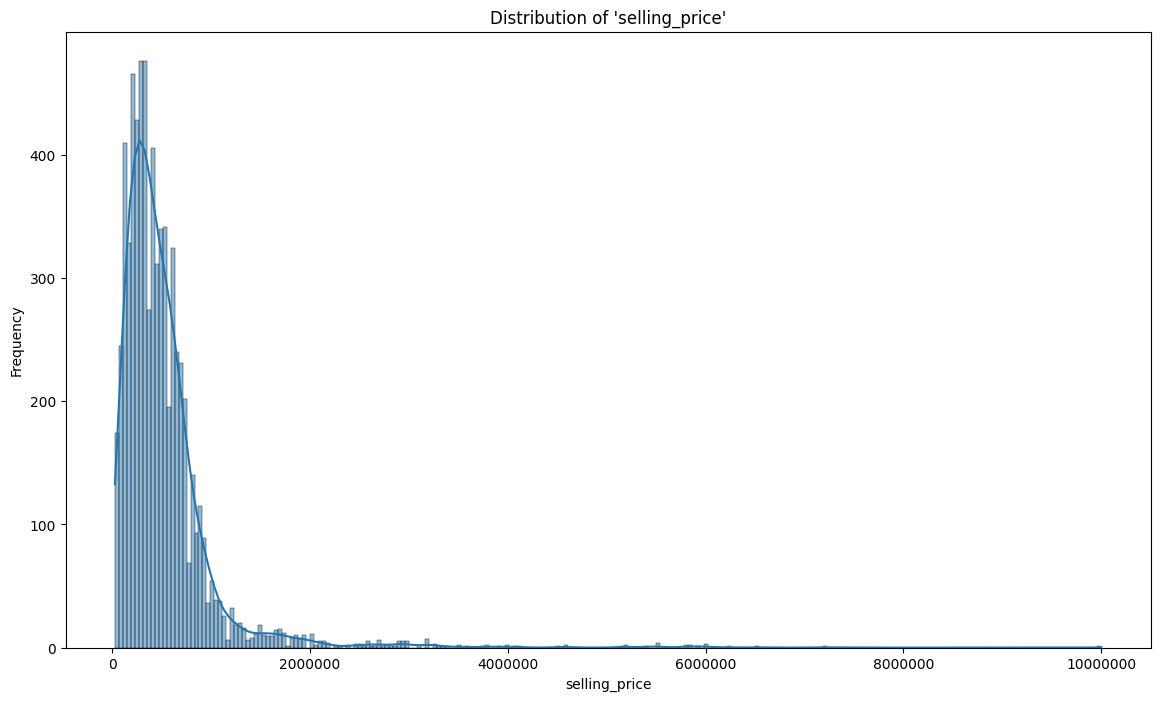

In [29]:
import matplotlib.ticker as mticker

# Histogram for selling_price
plt.figure(figsize=(14,8))
ax = sns.histplot(data=df_copy["selling_price"], kde=True)

plt.title("Distribution of 'selling_price'")
plt.xlabel("selling_price")
plt.ylabel("Frequency")

ax.xaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='x')

plt.savefig(f'{plots_saving_path}/selling_price_histogram_before_FE.png')
plt.show()
plt.close()


as mentioned in previous statistical analysis, selling price is right skewed which will be addressed in feature engineering

#### Numerical Features

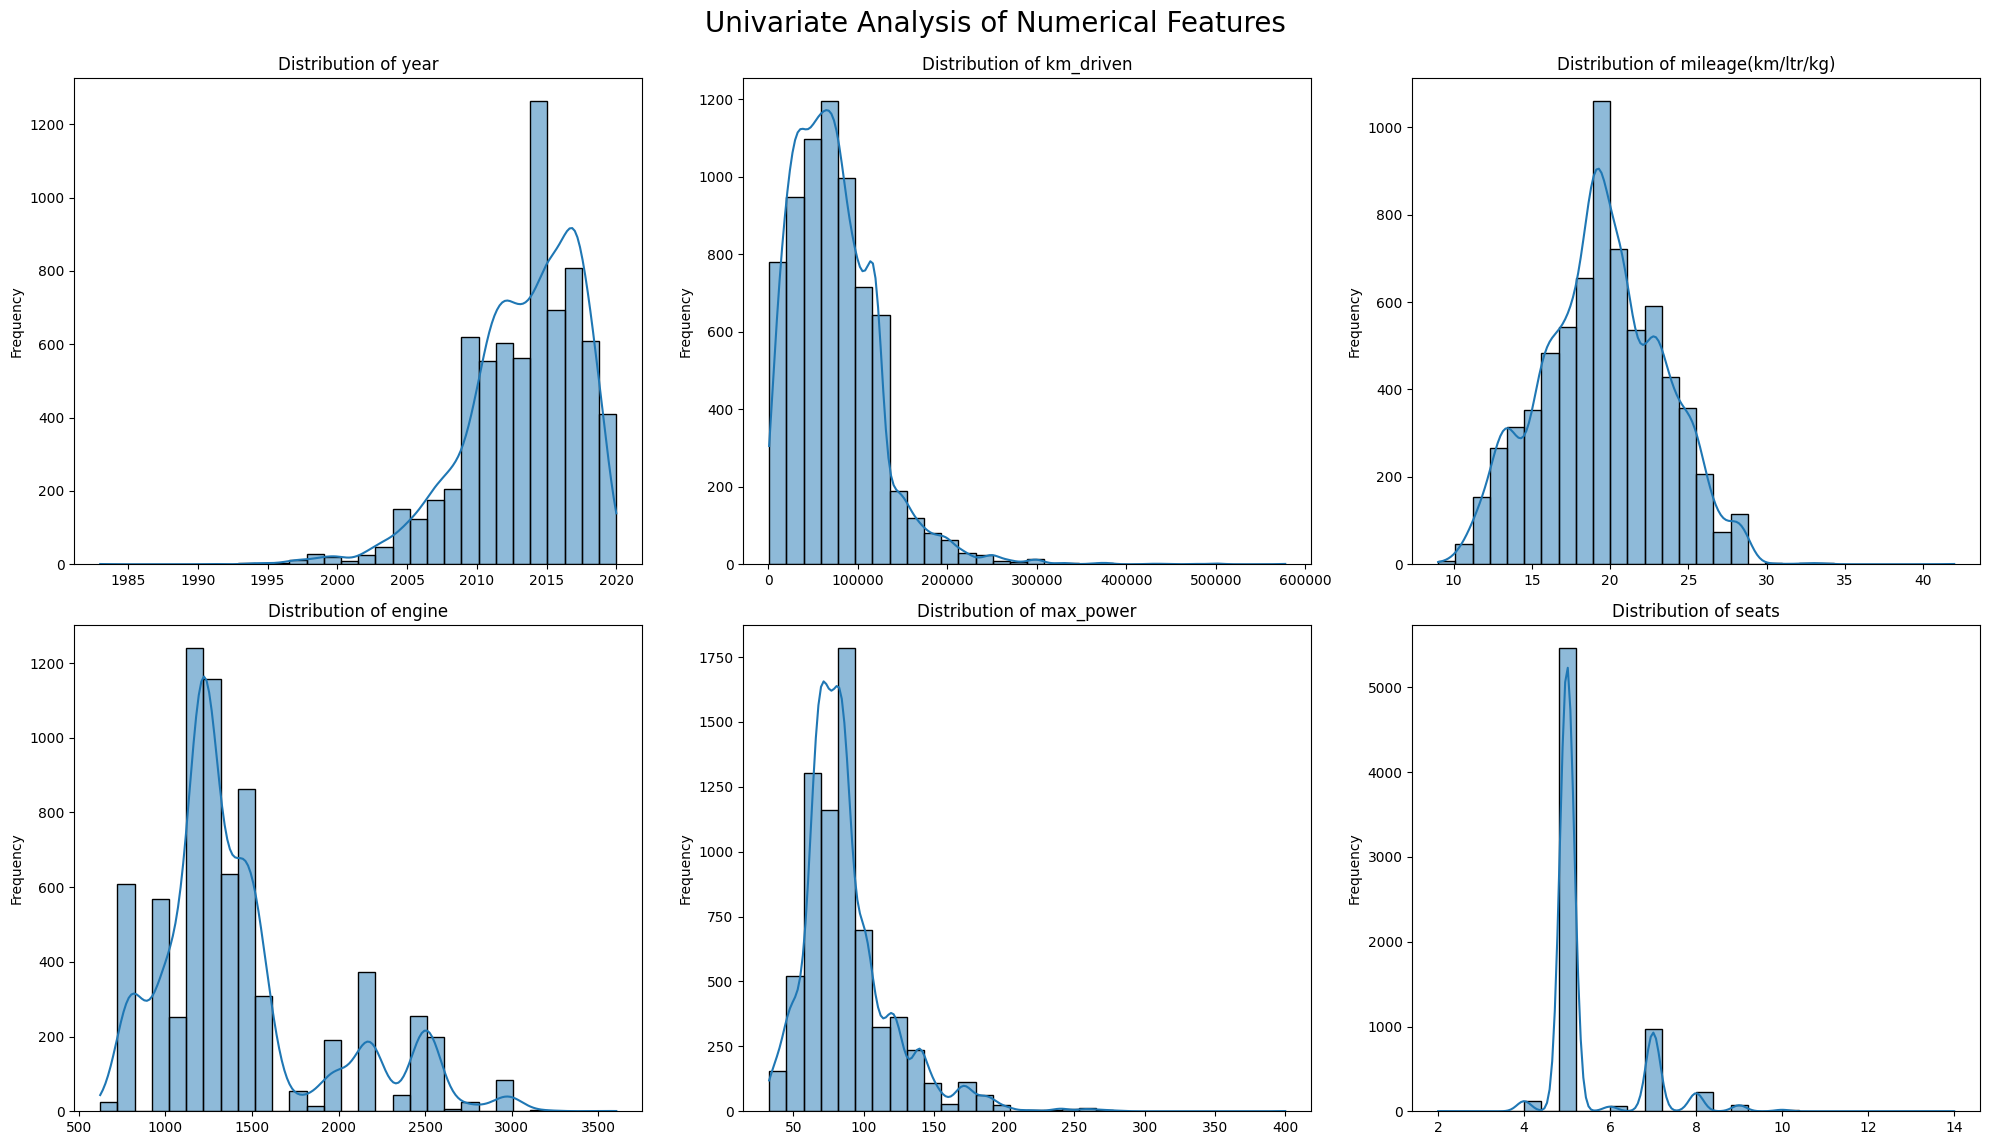

In [30]:
# Subplots for all numerical features
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Univariate Analysis of Numerical Features', fontsize=20)

numerical_cols = ['year', 'km_driven', 'mileage(km/ltr/kg)', 'engine', 'max_power', 'seats']

for col, ax in zip(numerical_cols, axes.flatten()):
    sns.histplot(data=df_copy, x=col, kde=True, ax=ax, bins=30)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')


plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.savefig(f'{plots_saving_path}/numerical_histogram_before_FE.png')
plt.show()
plt.close()

#### LLM comment 
*   **`year`:** The data is heavily **left-skewed**, with most cars manufactured after 2010.
*   **`km_driven` & `max_power`:** Both distributions are **right-skewed**, with most cars having lower mileage and power, but a long tail of high-performance/high-usage vehicles.
*   **`mileage(km/ltr/kg)`:** This is the most **normally distributed (bell-shaped)** feature, centered around 19-20 km/ltr.
*   **`engine`:** The distribution is **bimodal**, with a major peak around 1200cc (compact cars) and a smaller peak around 2200cc (SUVs), indicating distinct vehicle classes in the dataset.
*   **`seats`:** This is a **discrete distribution** dominated by **5-seater** cars, with a smaller, significant group of **7-seater** vehicles.

#### Categorical features
Before doing univariate analysis on categorical features, it is noticeable that the name feature starts with brand name trailed by the model, let's extract brand and model as brand value is crucial for resale prices.

In [31]:
# Extracting brand
df_copy['brand'] = df_copy['name'].apply(lambda x: x.split(' ')[0])

# Extracting model
df_copy['model'] = df_copy['name'].apply(lambda x: ' '.join(x.split(' ')[1:]))

# Droping name
df_copy.drop(columns=['name'], inplace=True)

print(df_copy.head())
print('\n---------------------\n')
print(df_copy["brand"].value_counts())

   year  selling_price  km_driven    fuel seller_type transmission  \
0  2014         450000     145500  Diesel  Individual       Manual   
1  2014         370000     120000  Diesel  Individual       Manual   
2  2006         158000     140000  Petrol  Individual       Manual   
3  2010         225000     127000  Diesel  Individual       Manual   
4  2007         130000     120000  Petrol  Individual       Manual   

          owner  mileage(km/ltr/kg)  engine  max_power  seats    brand  \
0   First Owner               23.40 1248.00      74.00   5.00   Maruti   
1  Second Owner               21.14 1498.00     103.52   5.00    Skoda   
2   Third Owner               17.70 1497.00      78.00   5.00    Honda   
3   First Owner               23.00 1396.00      90.00   5.00  Hyundai   
4   First Owner               16.10 1298.00      88.20   5.00   Maruti   

                    model  
0         Swift Dzire VDI  
1  Rapid 1.5 TDI Ambition  
2      City 2017-2020 EXi  
3       i20 Sportz Die

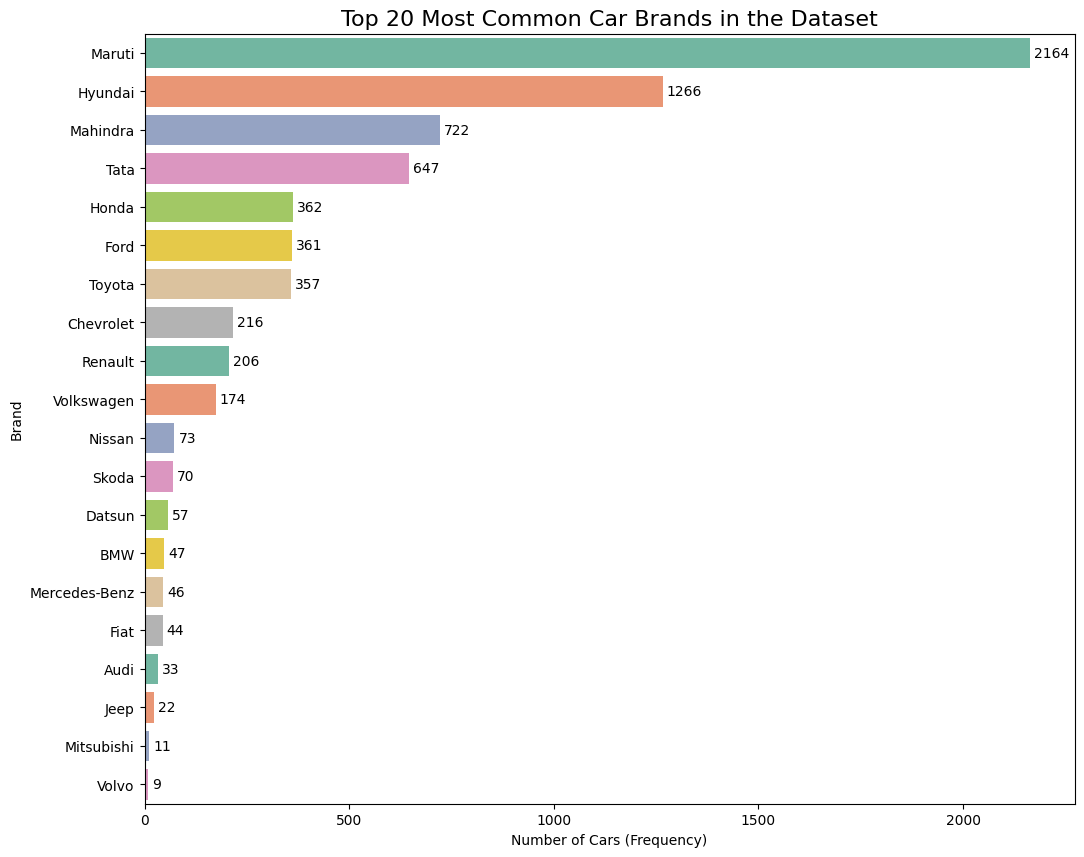

In [32]:
# Brand
plt.figure(figsize=(12, 10))
# Filtering top 20 brands
brand_counts = df_copy['brand'].value_counts().nlargest(20)

ax = sns.barplot(x=brand_counts.values, y=brand_counts.index, palette='Set2')

ax.set_title('Top 20 Most Common Car Brands in the Dataset', fontsize=16)
ax.set_xlabel('Number of Cars (Frequency)')
ax.set_ylabel('Brand')

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 10, p.get_y() + p.get_height() / 2, '{:d}'.format(int(width)), ha='left', va='center')

plt.savefig(f'{plots_saving_path}/brands_countplot.png')
plt.show()
plt.close()

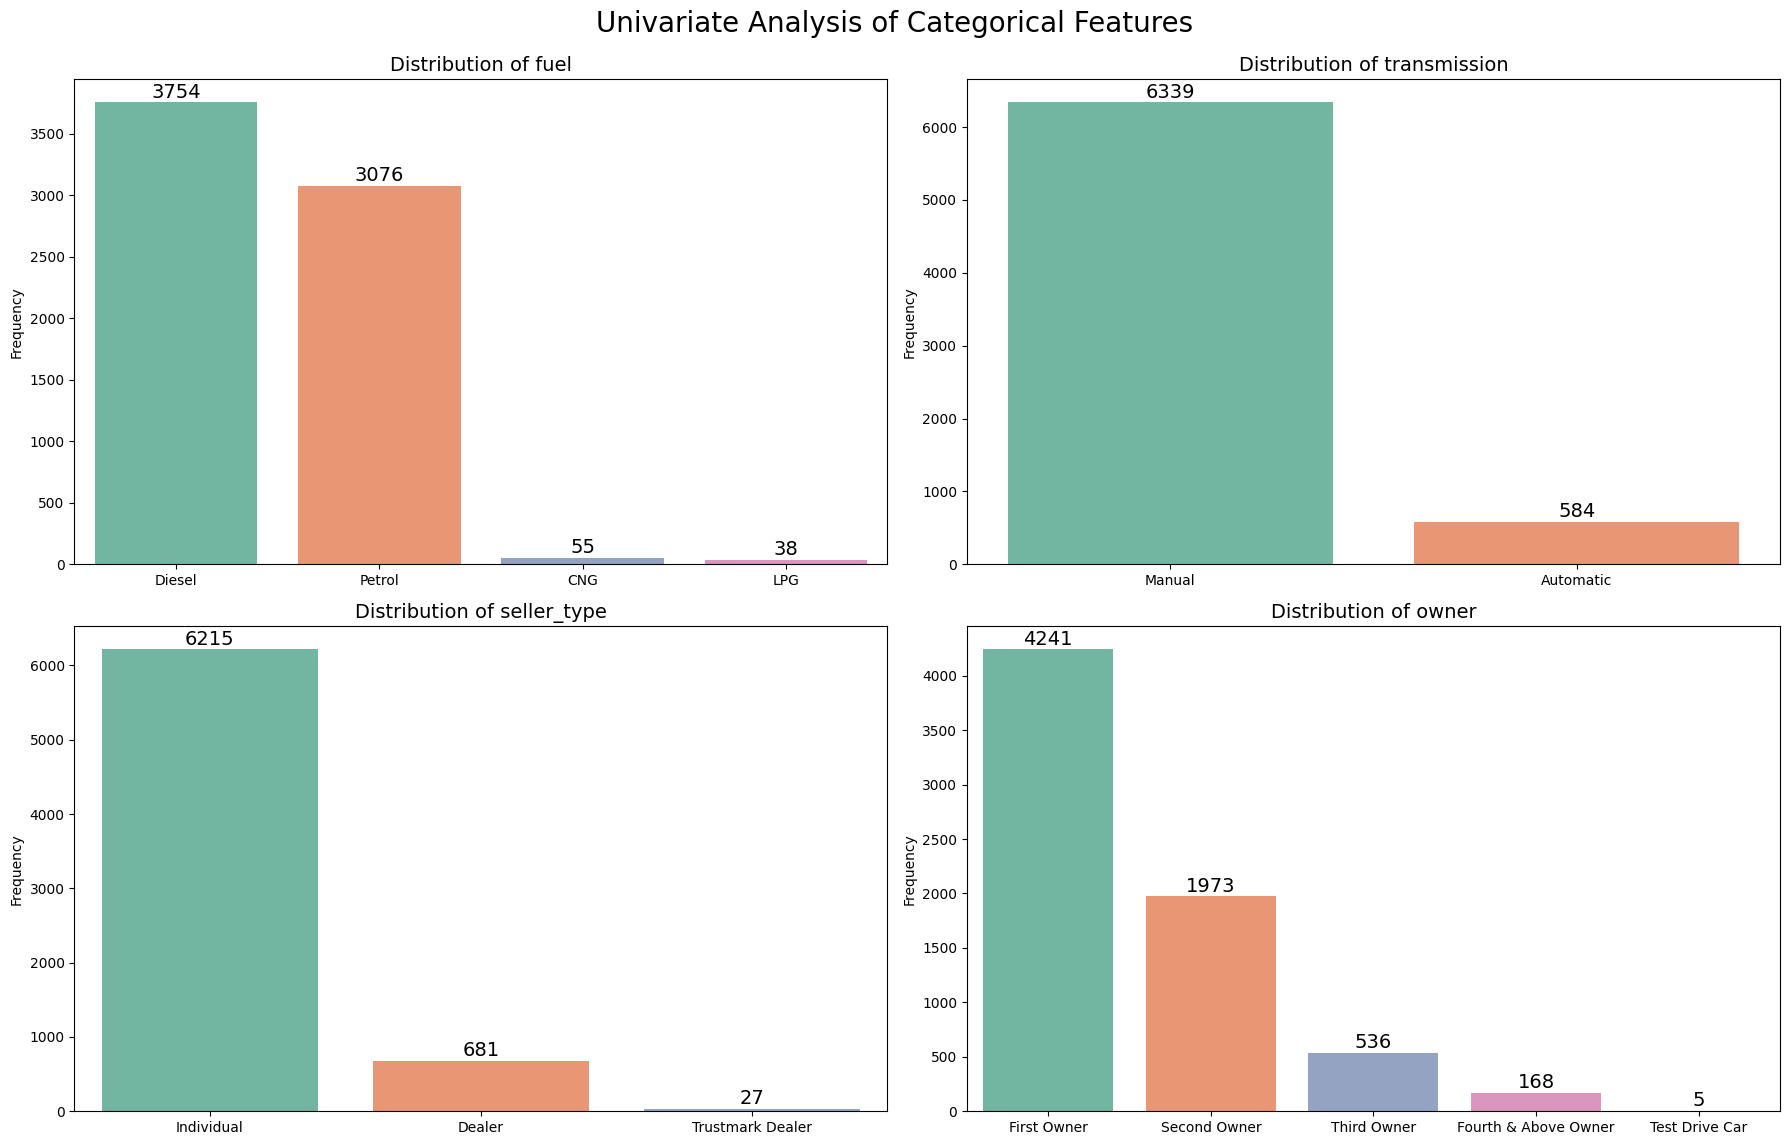

In [33]:
# Countplots for other categorical datas
categorical_cols = ['fuel', 'transmission', 'seller_type', 'owner']

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Univariate Analysis of Categorical Features', fontsize=20)

axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    ax = axes[i]
    sns.countplot(x=col, data=df_copy, ax=ax, palette='Set2', order=df_copy[col].value_counts().index)
    ax.set_title(f'Distribution of {col}', fontsize=14)
    ax.set_xlabel('') 
    ax.set_ylabel('Frequency')
    
    for p in ax.patches:
        height = p.get_height()
        ax.text(x=p.get_x() + p.get_width() / 2, y=height + (ax.get_ylim()[1] * 0.01), s=f'{int(height)}', ha='center', fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.savefig(f'{plots_saving_path}/categories_countplot.png')
plt.show()
plt.close()

#### LLM Comment
*   **`brand`**: Brands like **Maruti**, **Hyundai**, **Mahindra** and **Tata** dominate the dataset, which is representative of the Indian car market.
*   **`fuel`**: The dataset is fairly balanced between **Diesel (3754)** and **Petrol (3076)** cars, which are the dominant fuel types. CNG and LPG cars are very rare in comparison, which might make it hard for a model to learn their specific price patterns.

*   **`transmission`**: There is a significant class imbalance. **Manual** transmission cars **(6339)** vastly outnumber **Automatic** cars **(584)**. This is typical for the market but means the model will have much more data to learn from for manual cars.

*   **`seller_type`**: The dataset is overwhelmingly composed of cars sold by an **Individual (6215)**. Cars sold by **Dealers (681)** are much less common. This feature will likely be a strong indicator of price.

*   **`owner`**: Most cars are **First Owner (4241)**, followed by **Second Owner (1973)**. The number drops off sharply for third, fourth, and test drive cars. This confirms the expected trend that newer/less-used cars are more common on the market.

### Bivariate Analysis
#### Numerical Features

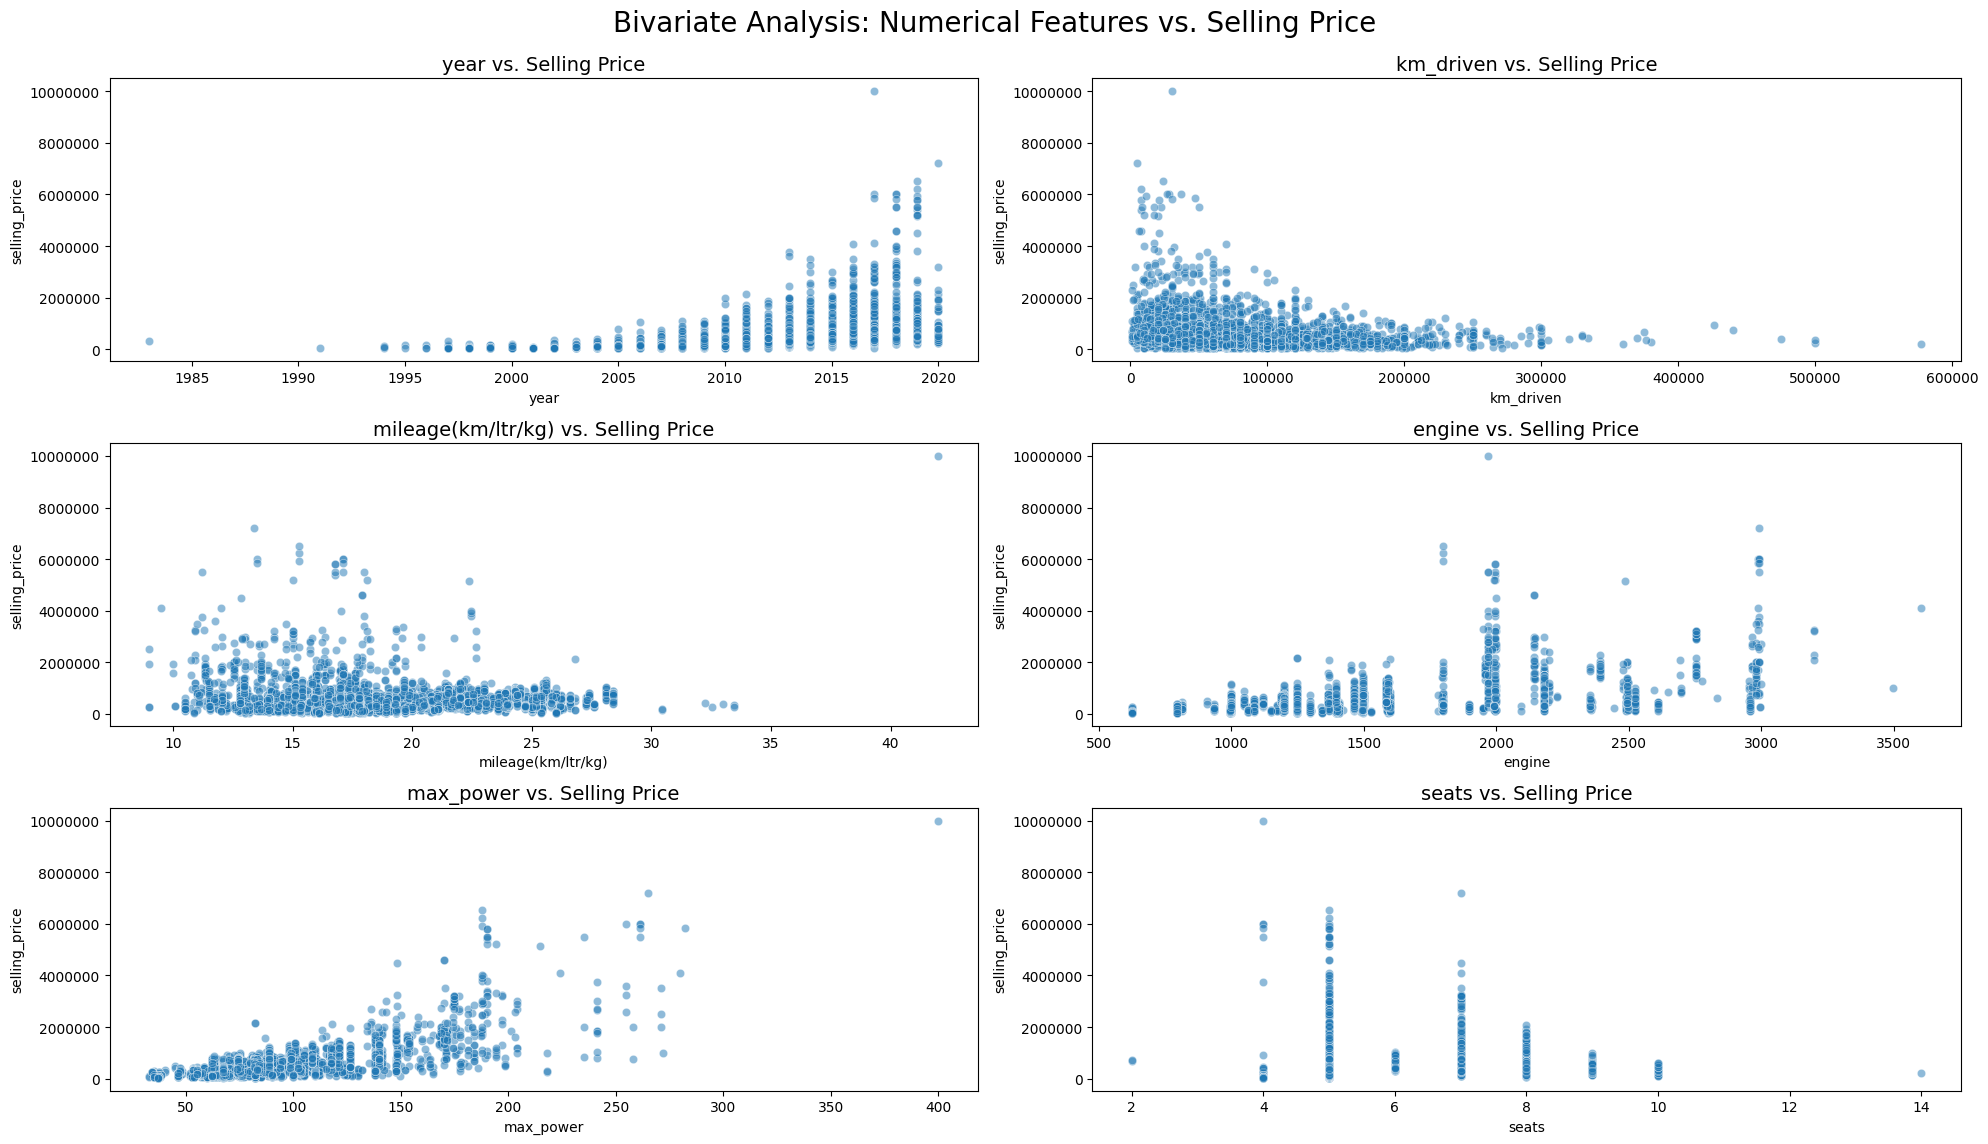

In [34]:
fig, axes = plt.subplots(3, 2, figsize=(20, 12))
fig.suptitle('Bivariate Analysis: Numerical Features vs. Selling Price', fontsize=20)

axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    ax = axes[i]
    sns.scatterplot(data=df_copy, x=col, y='selling_price', ax=ax, alpha=0.5)
    ax.set_title(f'{col} vs. Selling Price', fontsize=14)
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.ticklabel_format(style='plain', axis='y')
    ax.ticklabel_format(style='plain', axis='x')

plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.savefig(f'{plots_saving_path}/numerical_scatterplot.png')
plt.show()
plt.close()

#### LLM comment

*   **`year` vs. Price:** Strong positive correlation. Newer cars are more expensive.
*   **`km_driven` vs. Price:** Clear negative correlation. Higher mileage leads to lower prices.
*   **`max_power` & `engine` vs. Price:** Strong positive correlation. More powerful cars with larger engines are consistently more expensive. `max_power` shows a particularly strong linear trend.
*   **`mileage` vs. Price:** No strong or clear trend. The relationship is weak and scattered.
*   **`seats` vs. Price:** Acts like a categorical feature. While most cars are 5-seaters, cars with 7 or 8 seats can command higher prices.

#### Categorical Features


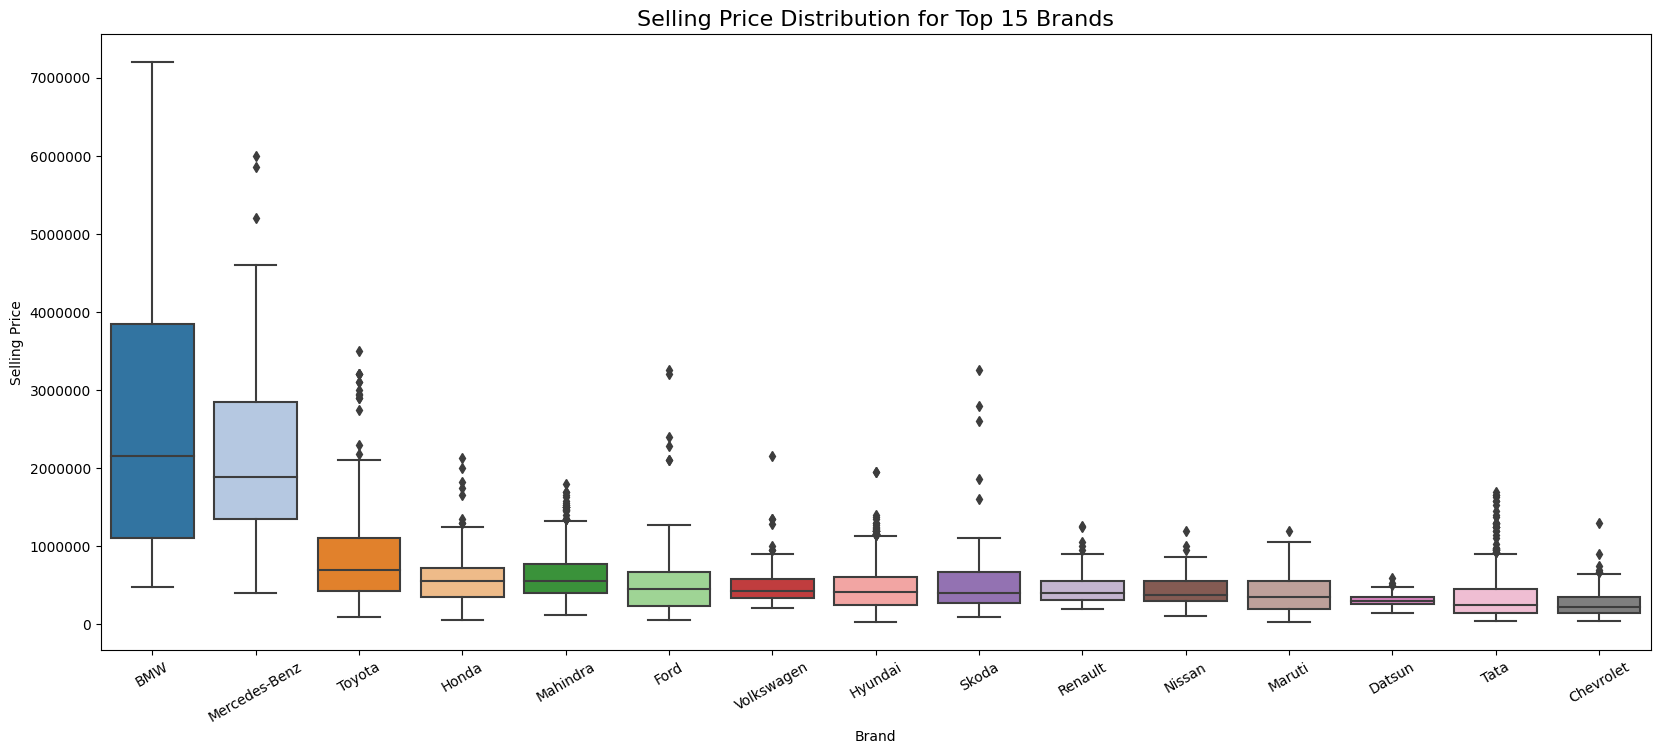

In [35]:
# Identify the top 15 most frequent brands
top_15_brands = df_copy['brand'].value_counts().nlargest(15).index

# Filter the DataFrame to only include these top brands
df_top_brands = df_copy[df_copy['brand'].isin(top_15_brands)]

# To make the plot more insightful, ordering the brands by their median selling price
brand_order = df_top_brands.groupby('brand')['selling_price'].median().sort_values(ascending=False).index

plt.figure(figsize=(20, 8))
ax_brand = sns.boxplot(x='brand', y='selling_price', data=df_top_brands, order=brand_order, palette='tab20')

ax_brand.set_title('Selling Price Distribution for Top 15 Brands', fontsize=16)
ax_brand.set_xlabel('Brand')
ax_brand.set_ylabel('Selling Price')
ax_brand.tick_params(axis='x', rotation=30)

# Use a non-scientific format for the y-axis
ax_brand.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax_brand.ticklabel_format(style='plain', axis='y')

plt.savefig(f'{plots_saving_path}/brands_boxplot.png')
plt.show()
plt.close()

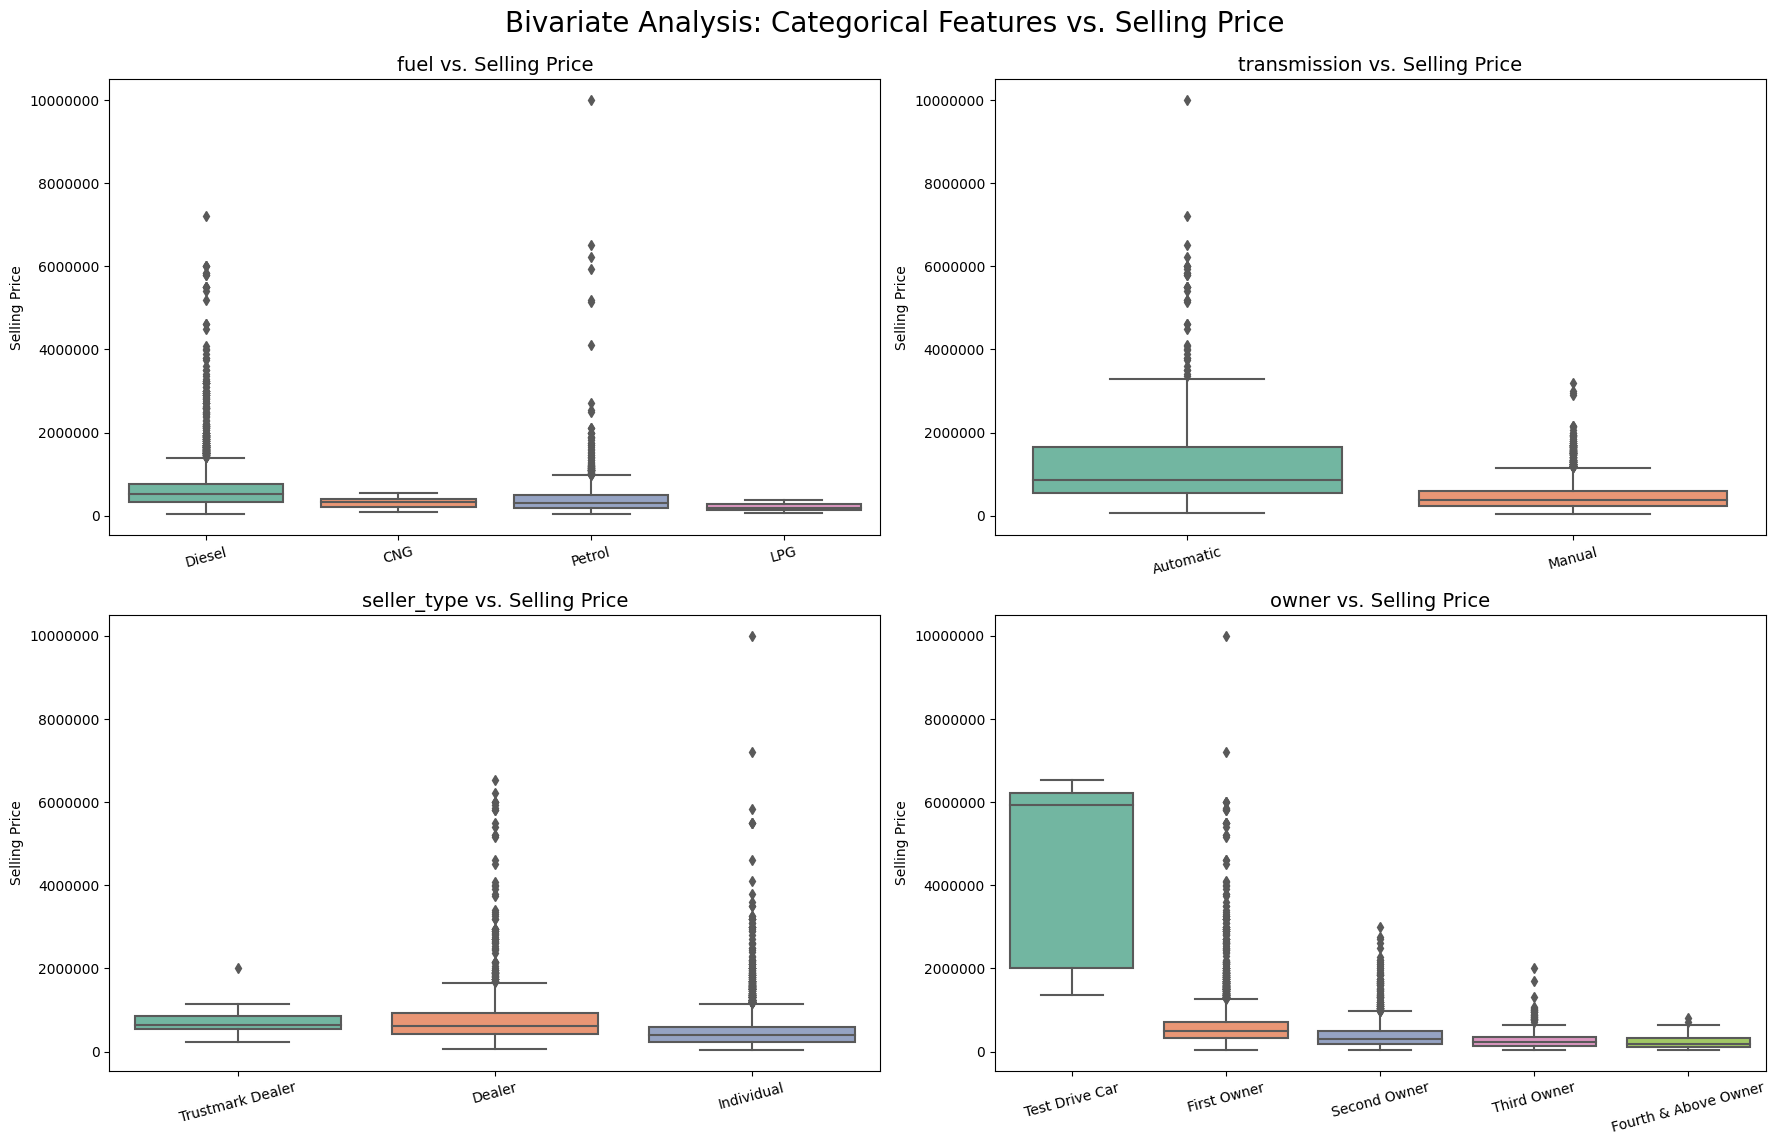

In [36]:
# Other categories
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Bivariate Analysis: Categorical Features vs. Selling Price', fontsize=20)

axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    ax = axes[i]
    
    order = df_copy.groupby(col)['selling_price'].median().sort_values(ascending=False).index
    
    # Create the box plot
    sns.boxplot(x=col, y='selling_price', data=df_copy, ax=ax, palette='Set2', order=order)
    
    ax.set_title(f'{col} vs. Selling Price', fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('Selling Price')
    
    # Format the y-axis to be readable (no scientific notation)
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.ticklabel_format(style='plain', axis='y')
    
    # Rotate labels if needed
    ax.tick_params(axis='x', rotation=15)

# Adjust the layout to prevent titles from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.savefig(f'{plots_saving_path}/categories_boxplot.png')
plt.show()
plt.close()

#### LLM comment
##### **Brand**
*   **Clear Price Hierarchy:** There's a distinct tier system. Luxury brands like `BMW` and `Mercedes-Benz` command the highest median prices. They are followed by a premium/SUV tier including `Toyota` and `Mahindra`. The majority of brands like `Honda`, `Hyundai`, and `Maruti` occupy a competitive mid-to-budget range.
*   **Outliers:** The dots (outliers) represent the most expensive models within a brand. For instance, the outliers for `Toyota` are likely the high-end `Fortuner` or `Innova Crysta` models, while the main box represents more common models like the `Etios`. These are valid data points and crucial for the model to understand the full price range of a brand.

##### **Other Categorical Features**

*   **`fuel`:** **Diesel** cars show a significantly higher median price and wider price distribution than Petrol cars. CNG and LPG cars are clustered at the low end, indicating they are primarily budget-friendly options.

*   **`transmission`:** **Automatic** cars are substantially more expensive than **Manual** cars. The difference in median price is very large, making this a powerful predictive feature.

*   **`seller_type`:** Cars sold by **Dealers** have a higher median price than those sold by **Individuals**. This is logical, as dealers often sell certified or newer vehicles. The "Test Drive Car" category in the `owner` plot shows a similar high-value trend.

*   **`owner`:** There is a clear, predictable **inverse relationship** between the number of previous owners and the selling price. **First Owner** cars are the most expensive, and the price drops consistently for Second, Third, and subsequent owners.

**Overall Conclusion:**
All these categorical features show strong, logical relationships with the selling price. `brand`, `transmission`, and `owner` appear to be particularly strong predictors. The outliers are not errors but represent real, high-end models within each category, providing valuable information for the model.

#### Correlation matrix

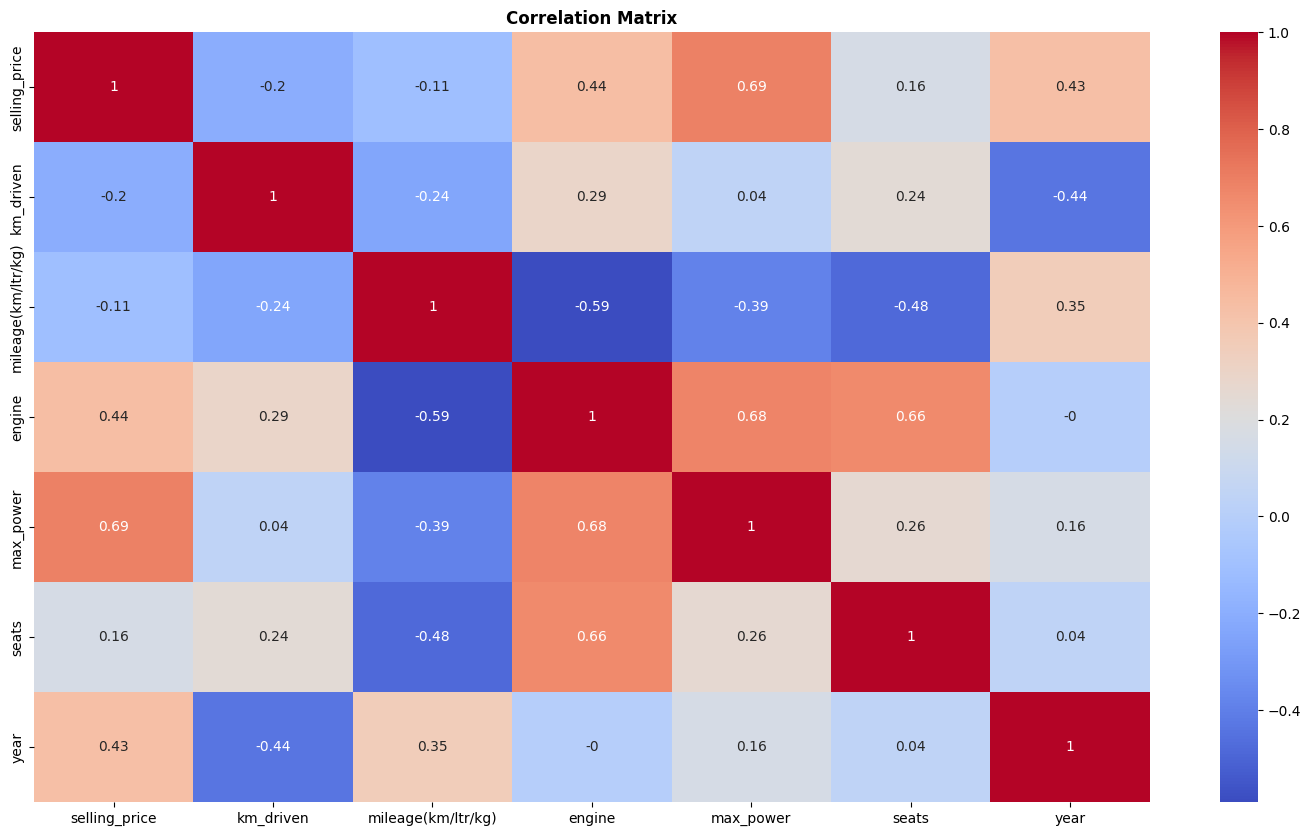

In [37]:
# Correlation matrix
numerical_cols_for_corr = ['selling_price', 'km_driven', 'mileage(km/ltr/kg)', 'engine', 'max_power', 'seats', 'year']
corr_matrix = df_copy[numerical_cols_for_corr].corr().round(2)

plt.figure(figsize = (18,10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix', fontweight='bold')
plt.savefig(f'{plots_saving_path}/corr_matrix.png')
plt.show()
plt.close()

#### LLM comment

#### **Relationships with `selling_price` (The First Row/Column):**

*   **`max_power` (Correlation: 0.69):** This is the **strongest positive correlation**. As max power increases, the selling price tends to increase significantly. This confirms what we saw in the scatter plot.
*   **`year` (Correlation: 0.43):** A solid **positive correlation**. As the year increases (car gets newer), the price increases. This justifies our plan to create a `car_age` feature, which will have a strong negative correlation.
*   **`engine` (Correlation: 0.44):** A good **positive correlation**. Larger engines are associated with higher prices.
*   **`km_driven` (Correlation: -0.20):** A **weak-to-moderate negative correlation**. As kilometers increase, the price tends to decrease. The correlation isn't stronger because the relationship is likely not perfectly linear.
*   **`mileage` (Correlation: -0.11):** A very **weak negative correlation**. This suggests that fuel efficiency, by itself, is not a strong linear predictor of price.

#### **Relationships Between Other Features (Multicollinearity):**

*   **`engine` and `max_power` (Correlation: 0.68):** There is a **strong positive correlation** between engine size and max power. This is completely logical—bigger engines are generally more powerful. This is a classic case of multicollinearity.
*   **`engine` and `mileage` (Correlation: -0.59):** A **strong negative correlation**. Bigger engines tend to have lower fuel efficiency (mileage). This also makes perfect sense.
*   **`year` and `km_driven` (Correlation: -0.44):** A moderate **negative correlation**. Older cars (lower year) tend to have been driven more kilometers.


## Feature Engineering
### New Features
- **`brand`** and **`model`** features are already extracted from **`name`**
- Other features recommended by LLM are:
    - **`car_age`**: While `year` is a good predictor, `car_age` (`current_year - year`) provides a more direct and intuitive measure of depreciation. A model can more easily learn a simple negative relationship ("older cars are cheaper") than a positive one tied to a specific year. This feature is also more robust over time.
    - **`km_per_year` (from `km_driven` and `car_age`)**: This feature captures the **intensity of usage**, which is more telling than total mileage alone. A 2-year-old car with 50,000 km has been used much more heavily than a 10-year-old car with the same mileage. This provides a richer signal about the car's condition and potential wear.
---
#### **Potential Future Features**

For this project, we are focusing on the most impactful and standard features first. The following are excellent ideas for future improvements but would add complexity that isn't necessary for building a strong initial model.

*   **`is_luxury` (Binary Flag):**
    *   **What:** A `1` if the brand is a known luxury brand (BMW, Audi, etc.), otherwise `0`.
    *   **Why not now?** Powerful tree-based models like XGBoost can learn this distinction implicitly from the one-hot encoded `brand` feature. While a good idea, it's not essential for the first version.

*   **`power_to_engine_ratio`:**
    *   **What:** `max_power / engine`.
    *   **Why not now?** This captures engine efficiency, but the individual `max_power` and `engine` features are already very strong predictors. This new feature might add only marginal value while making the model slightly more complex.

Sticking to `car_age` and `km_per_year` is a robust and efficient strategy to get a high-performing baseline model.

In [38]:
# The final cleaned and feature added dataset 
df_final = df_copy.copy()

# Extracting 'car_age' feature
# Setting the current_year relative to the data's latest entry rather than the current year
current_year = df_final['year'].max() + 1
df_final['car_age'] = current_year - df_final['year']

# Creating 'km_per_year'
df_final['km_per_year'] = df_final['km_driven'] / df_final['car_age']

df_final.drop(columns=['year'], inplace=True)
df_final.head()

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats,brand,model,car_age,km_per_year
0,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.00,74.00,5.00,Maruti,Swift Dzire VDI,7,20785.71
1,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.00,103.52,5.00,Skoda,Rapid 1.5 TDI Ambition,7,17142.86
2,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.00,78.00,5.00,Honda,City 2017-2020 EXi,15,9333.33
3,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.00,90.00,5.00,Hyundai,i20 Sportz Diesel,11,11545.45
4,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.00,88.20,5.00,Maruti,Swift VXI BSIII,14,8571.43


In [39]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6923 entries, 0 to 8125
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   selling_price       6923 non-null   int64  
 1   km_driven           6923 non-null   int64  
 2   fuel                6923 non-null   object 
 3   seller_type         6923 non-null   object 
 4   transmission        6923 non-null   object 
 5   owner               6923 non-null   object 
 6   mileage(km/ltr/kg)  6923 non-null   float64
 7   engine              6923 non-null   float64
 8   max_power           6923 non-null   float64
 9   seats               6923 non-null   float64
 10  brand               6923 non-null   object 
 11  model               6923 non-null   object 
 12  car_age             6923 non-null   int64  
 13  km_per_year         6923 non-null   float64
dtypes: float64(5), int64(3), object(6)
memory usage: 811.3+ KB


In [40]:
df_final.describe()

,selling_price,km_driven,mileage(km/ltr/kg),engine,max_power,seats,car_age,km_per_year
count,6923.00,6923.00,6923.00,6923.00,6923.00,6923.00,6923.00,6923.00
mean,517312.97,73470.11,19.50,1425.36,87.59,5.42,7.58,10603.61
std,519866.21,48549.41,3.88,487.03,31.26,0.97,4.08,6964.73
min,29999.00,1000.00,9.00,624.00,32.80,2.00,1.00,200.00
25%,250000.00,40000.00,17.00,1197.00,68.00,5.00,4.00,6153.85
50%,400000.00,70000.00,19.33,1248.00,81.86,5.00,7.00,9166.67
75%,634500.00,100000.00,22.32,1498.00,99.00,5.00,10.00,13333.33
max,10000000.00,577414.00,42.00,3604.00,400.00,14.00,38.00,120000.00


In [41]:
# Saving this final cleaned dataset with new features before feature scaling
df_final.to_csv("./car_processed.csv", index=False)

### Feature Scaling
While Feature scaling is not necessary to our tree based model considerations, to give linear models like ridge regression, KNN and SVM their best shot, we will log transform right skewed target and features with standard scaling. 

### Train-test Split
The dataset will be split in 80:20 train and test split. While a val split could be made: I am going to use cross_val_score ,and RandomSearchCV with 5 fold cross validation to validate model's best parameters. 

In [42]:
# Separating features and target
X = df_final.drop('selling_price', axis=1)
y = df_final['selling_price']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Instances in train: {len(y_train)}')
print(f'Instance in test: {len(y_test)}')

Instances in train: 5538
Instance in test: 1385


In [43]:
# From our EDA, we know these are skewed
skewed_features = ['km_driven', 'max_power', 'engine', 'km_per_year']

# All other numerical features
non_skewed_numerical_features = ['seats', 'car_age'] # 'car_age' is less skewed

categorical_features = X.select_dtypes(include='object').columns.tolist()

#### Log Transformation

In [44]:
X_train_scaled = X_train.copy()
y_train_scaled = y_train.copy()

for col in skewed_features:
    X_train_scaled[col] = np.log1p(X_train_scaled[col])

y_train_logged = np.log1p(y_train_scaled)

##### Selling price histogram

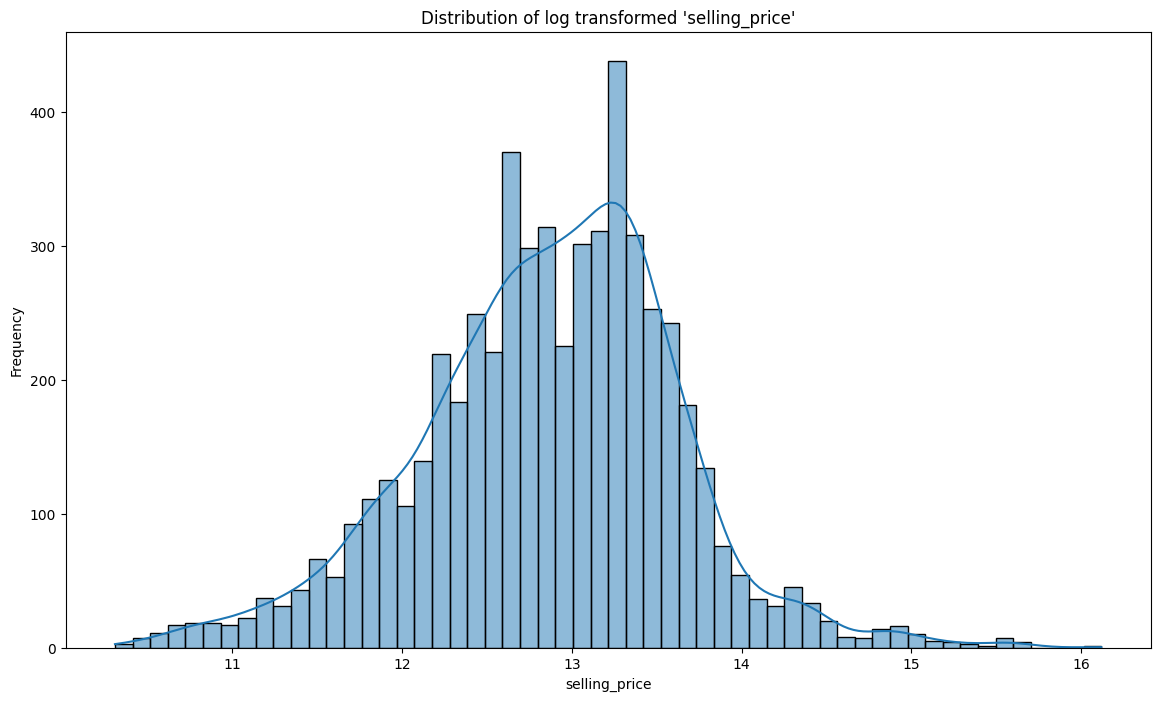

In [45]:
# Histogram for selling_price
plt.figure(figsize=(14,8))
ax = sns.histplot(data=y_train_logged, kde=True)

plt.title("Distribution of log transformed 'selling_price'")
plt.xlabel("selling_price")
plt.ylabel("Frequency")

ax.ticklabel_format(style='plain', axis='x')

plt.show()
plt.close()


##### Log-transforming other skewed features

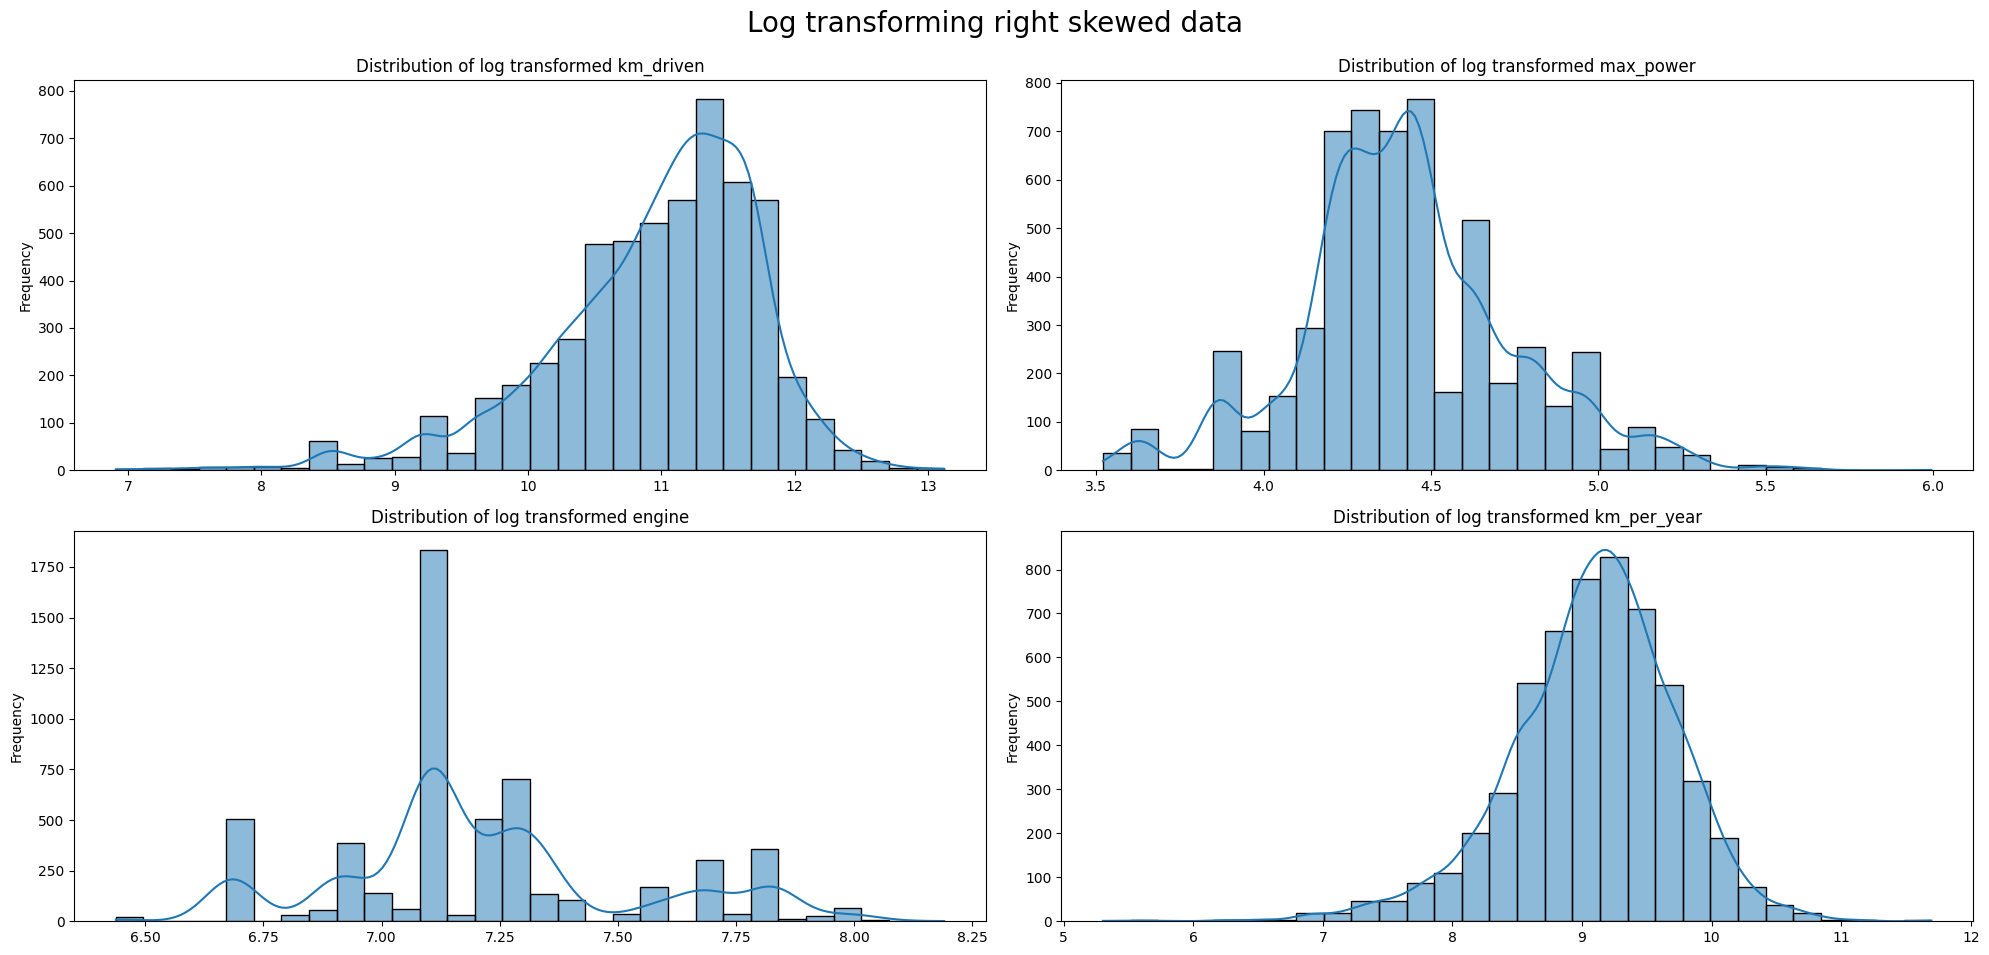

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Log transforming right skewed data', fontsize=20)

for col, ax in zip(skewed_features, axes.flatten()):
    sns.histplot(data=X_train_scaled, x=col, kde=True, ax=ax, bins=30)
    ax.set_title(f'Distribution of log transformed {col}')
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')


plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()
plt.close()

#### LLM comment
The log transformation successfully symmetrizes most features. Interestingly, `km_driven` becomes left-skewed after the transformation, which reflects the high concentration of relatively low-mileage cars in the original dataset. Nevertheless, this transformed feature is still more suitable for linear models than the original version due to the reduced influence of extreme high-mileage outliers

#### StandardScaler

In [47]:
numerical_features = X_train.select_dtypes(include=np.number).columns

# Initialize the scaler
scaler = StandardScaler()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train_scaled[numerical_features])


In [48]:
print(numerical_features)

Index(['km_driven', 'mileage(km/ltr/kg)', 'engine', 'max_power', 'seats',
       'car_age', 'km_per_year'],
      dtype='object')


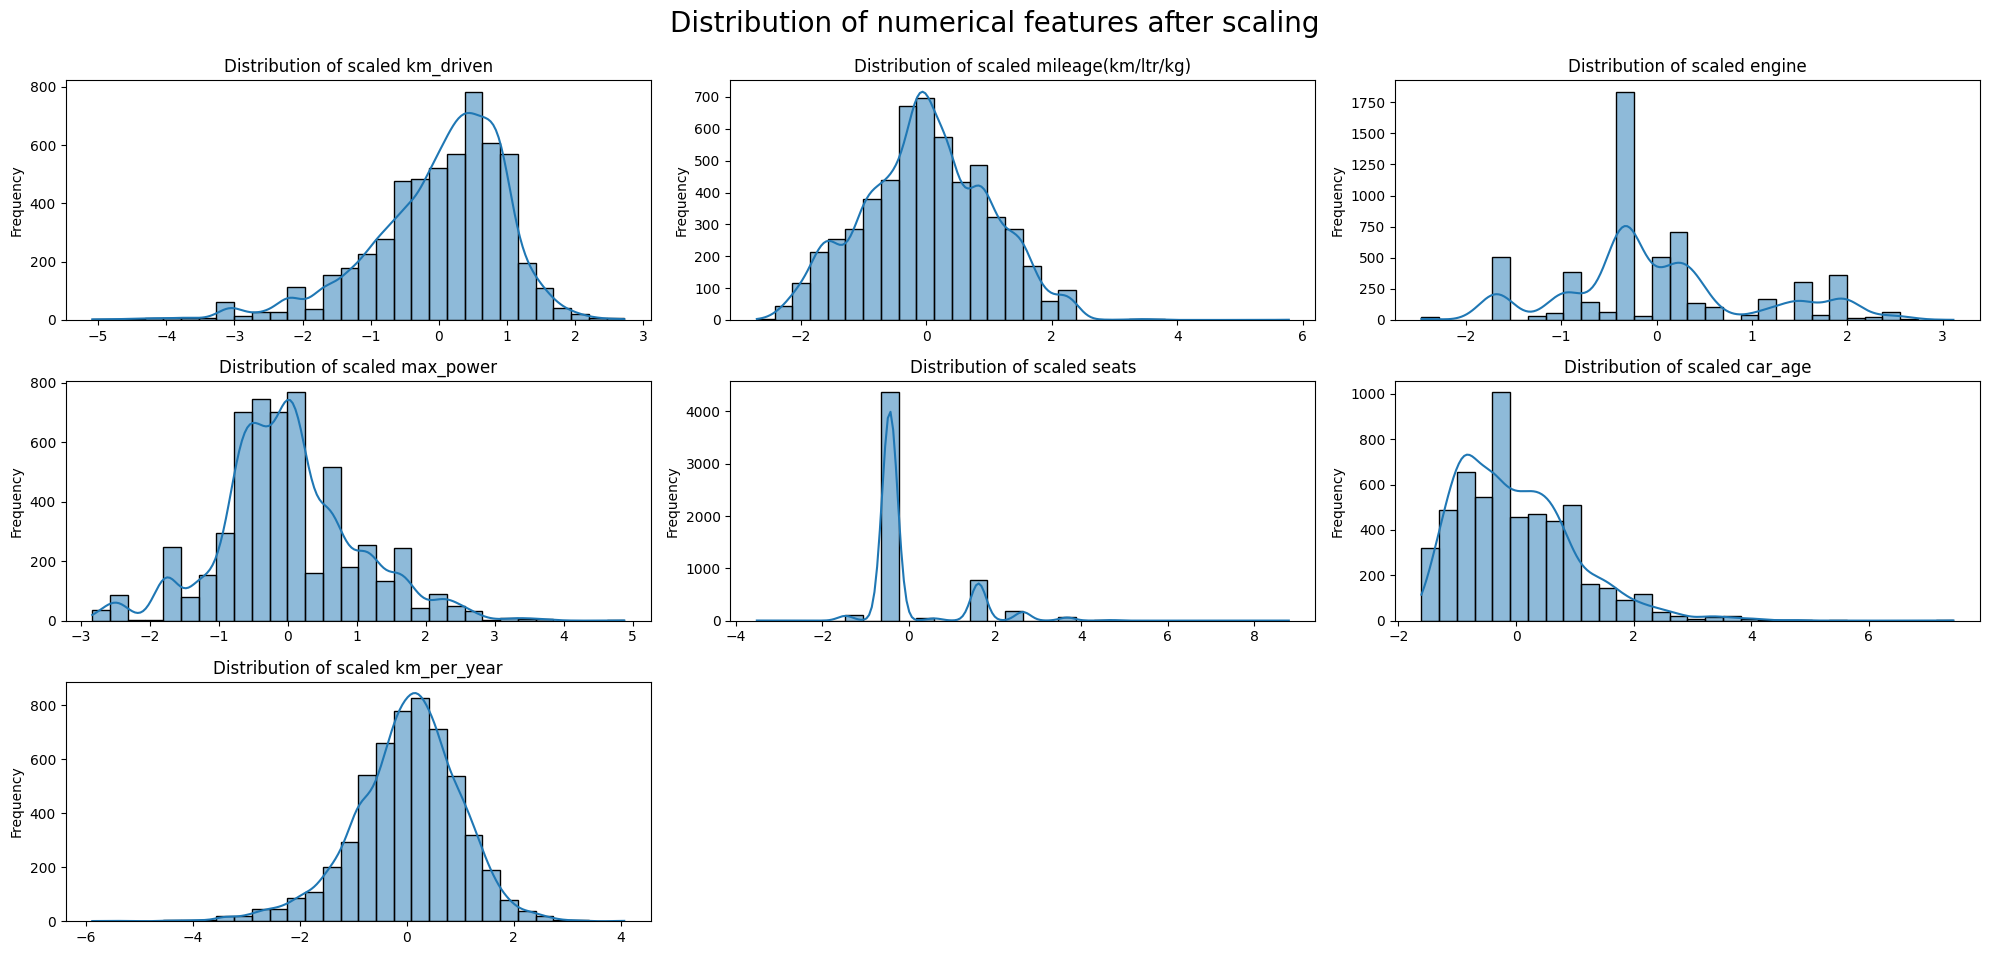

In [49]:
fig, axes = plt.subplots(3, 3, figsize=(20, 10))
fig.suptitle('Distribution of numerical features after scaling', fontsize=20)

for i, (col, ax) in enumerate(zip(numerical_features, axes.flatten())):
    sns.histplot(data=X_train_scaled, x=col, kde=True, ax=ax, bins=30)
    ax.set_title(f'Distribution of scaled {col}')
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')

# Hide the last 2 unused subplots
for j in range(i + 1, len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.savefig(f'{plots_saving_path}/numerical_histogram_after_FE.png')
plt.show()
plt.close()

#### LLM comment
**Standard-Scaled Features:** All numerical features are now on a common scale (mean=0, std=1), which prevents features with large original values from dominating the model. The underlying shapes of their original distributions have been correctly preserved.

### Feature Importance
For feature selection we fit our data to ExtraTreesRegressor ,which is often superior to simpler statistical methods because it can capture non-linear relationships and feature interactions. But, why ExtraTreesRegressor rather than other models that too provide feature ranking? <br/> ExtraTreesRegressor is popular for feature selection because its extreme randomness robustly identifies important features while aggressively suppressing noise, making it faster and more reliable than many alternatives. <br/> ExtraTreesRegressor is a tree model, thus there's no point in fitting scaled data. So the model will be fit with clean unscaled data.

Finding important features...


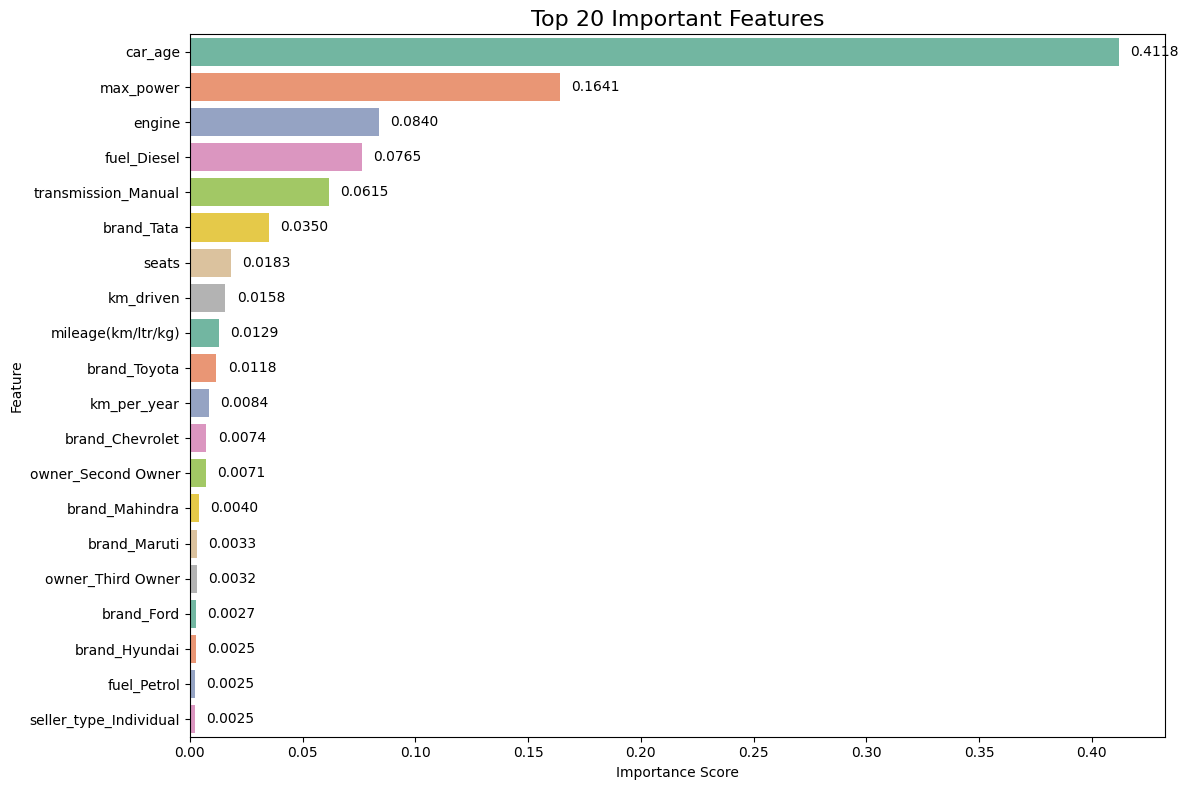

In [50]:
# One Hot encoding categorical datas
X_train_encoded = pd.get_dummies(X_train, drop_first=True)

# Fit clean dataset to ExtraTreesRegressor
selector_model = ExtraTreesRegressor(n_estimators=100, random_state=42, n_jobs=-1)
print("Finding important features...")
selector_model.fit(X_train_encoded, y_train_logged)

# Extracting the feature importances
importances = selector_model.feature_importances_
feature_names = X_train_encoded.columns 
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plotting the top N most important features
plt.figure(figsize=(12, 8))

top_n = 20  # Adjust as needed
top_features = feature_importance_df.head(top_n)

ax = sns.barplot(
    x='importance',
    y='feature',
    data=top_features,
    palette='Set2' 
)

ax.set_title(f'Top 20 Important Features', fontsize=16)
ax.set_xlabel('Importance Score')
ax.set_ylabel('Feature')

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.005, p.get_y() + p.get_height() / 2, f'{width:.4f}', ha='left', va='center',fontsize=10)

plt.tight_layout()
plt.savefig(f'{plots_saving_path}/feature_importance.png')  
plt.show()
plt.close()

#### LLM comment
*   **`car_age` is the Most Dominant Predictor (Importance: 0.41):** A car's age is, by a significant margin, the most important feature. It alone accounts for over 41% of the model's decision-making power, indicating that depreciation over time is the primary factor in a used car's value.

*   **The Power-Train Trio:** `max_power` (0.16), `engine` (0.08), and `fuel_Diesel` (0.08) are the next most critical features. This highlights that a car's raw performance (power and engine size) and its fuel type are fundamental to its pricing tier.

*   **Transmission is Key:** `transmission_Manual` (0.06) is also a top-tier feature, confirming that the distinction between manual and automatic transmissions is a major price driver.

*   **Specific Brands Matter:** It is noteworthy that specific brands, such as `brand_Tata` and `brand_Toyota`, appear in the top features. This suggests that certain brands carry a distinct price signal beyond their general specifications.

---

However, the features after one hot encoding categorical datas like brand and model will cause feature overcrowding. Thus, SelectFromModel will be trained in the pipeline to learn selection of top 35 features 

## Model Building and Evaluation
### Baselines
From the baseline models, cross validated R² score are to be used for determining and comparing baseline performance. The pipelines covers:
- Use different preprocessor for tree and linear model, as tree models do not benefit from scaling features
- skewed numerical features are log transformed and standardized while non-skewed features are standardized
- categorical features are on hot encodded
- target `selling_price` is log transformed
- ExtraTreeRegressor and SelectFromModel in Pipeline to select 35 important features

In [51]:
# Identifying features in same cell 
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = ['fuel', 'seller_type', 'transmission', 'owner', 'brand', 'model']
skewed_features = ['km_driven', 'max_power', 'engine', 'km_per_year']
non_skewed_numerical_features = [col for col in numerical_features if col not in skewed_features]

In [52]:
# Preprocessing transformers

# Transformer for skewed features
skewed_transformer = Pipeline(steps=[
    ('log1p', FunctionTransformer(np.log1p)),
    ('scaler', StandardScaler())
])

# Preprocessor for LINEAR/DISTANCE models
preprocessor_linear = ColumnTransformer(
    transformers=[
        ('skewed', skewed_transformer, skewed_features),
        ('non_skewed', StandardScaler(), non_skewed_numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

# Preprocessor for TREE models
preprocessor_tree = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

# Models to benchmark and preprocessor used
models_to_benchmark = [
    ('Ridge', Ridge(random_state=42), preprocessor_linear),
    ('SVR', SVR(), preprocessor_linear),
    ('KNeighbors', KNeighborsRegressor(), preprocessor_linear),
    ('RandomForest', RandomForestRegressor(random_state=42), preprocessor_tree),
    ('GradientBoosting', GradientBoostingRegressor(random_state=42), preprocessor_tree),
    ('XGBoost', XGBRegressor(random_state=42), preprocessor_tree),
    ('LightGBM', LGBMRegressor(random_state=42, verbosity=-1), preprocessor_tree)
]

In [53]:
# Benchmark function that does cross validation 
def benchmark_model_r2(model_name, model_pipeline, X, y, cv_folds=5):
    print(f"Benchmarking {model_name}...")
    r2_scores = cross_val_score(model_pipeline, X, y, cv=cv_folds, scoring='r2', n_jobs=-1)
    print(f"-> Mean R²: {r2_scores.mean():.4f} (Std Dev: {r2_scores.std():.4f})\n")
    return model_name, r2_scores

In [54]:
all_cv_results = []

for name, model, preprocessor in models_to_benchmark:
    # Pipeline that wraps preprocessing, feature selection and model to train
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('selector', SelectFromModel(ExtraTreesRegressor(n_estimators=100, random_state=42), max_features=35)),
        ('model', model)
    ])
    
    # Wrap the entire pipeline in the target transformer
    final_pipeline = TransformedTargetRegressor(
        regressor=pipeline,
        func=np.log1p,
        inverse_func=np.expm1
    )
    
    # Using benchmark_model_r2 function to get the R² scores
    model_name, r2_scores = benchmark_model_r2(name, final_pipeline, X_train, y_train)
    all_cv_results.append((model_name, r2_scores))

Benchmarking Ridge...


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown

-> Mean R²: 0.8062 (Std Dev: 0.0533)

Benchmarking SVR...


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown

-> Mean R²: 0.8299 (Std Dev: 0.0967)

Benchmarking KNeighbors...


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown

-> Mean R²: 0.8052 (Std Dev: 0.0530)

Benchmarking RandomForest...


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown

-> Mean R²: 0.8780 (Std Dev: 0.0410)

Benchmarking GradientBoosting...


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown

-> Mean R²: 0.8694 (Std Dev: 0.0400)

Benchmarking XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown

-> Mean R²: 0.8850 (Std Dev: 0.0552)

Benchmarking LightGBM...


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


-> Mean R²: 0.8711 (Std Dev: 0.0494)



/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


**About the warnings**: One Hot Encoder genereated warnings as the validation fold can contain unique categories which is not present in four folds that the encoder fits. This might slightly and temporarily lower the performance score for that specific fold, but it's a realistic representation of how the model will perform. To avoid this - prefitting a one hot encoder to get all the predefined categories for the encoder in pipeline.

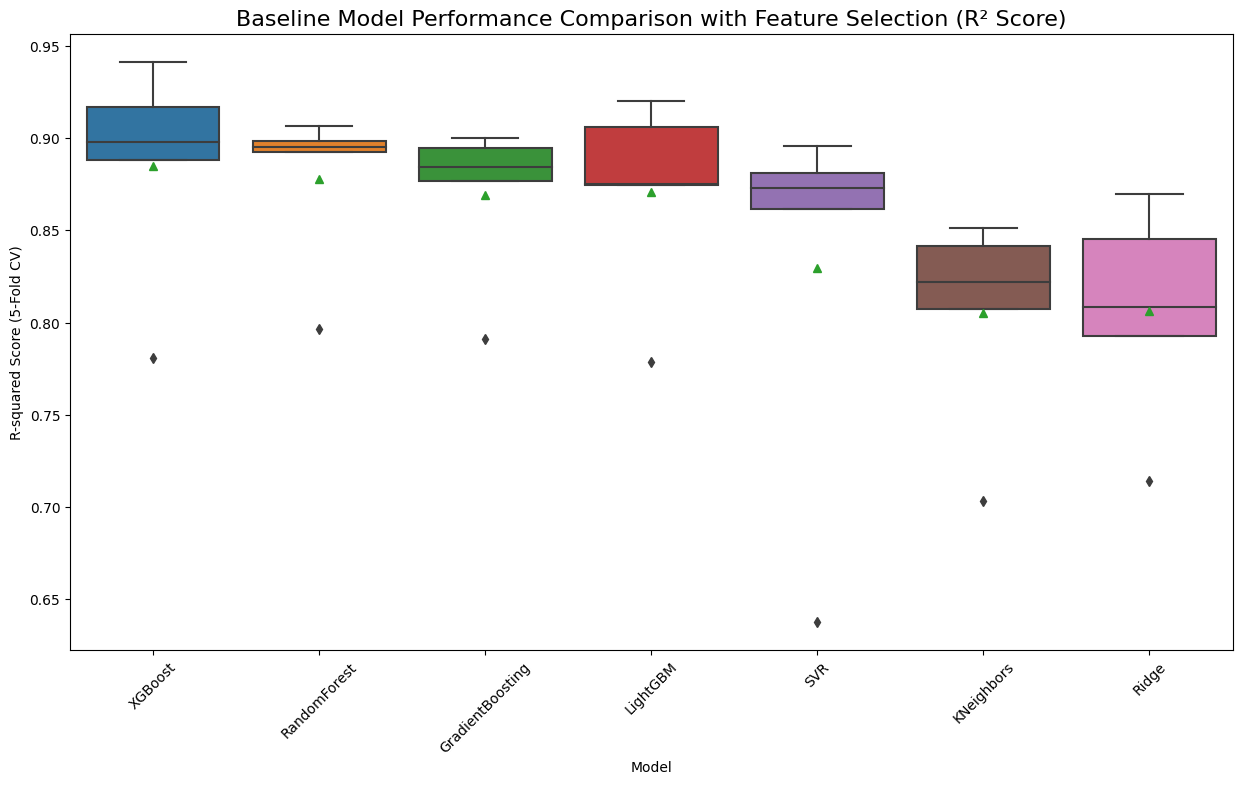

In [55]:
# Visualizing baseline training
names = [result[0] for result in all_cv_results]
scores = [result[1] for result in all_cv_results]

plot_data = []
for name, score_array in zip(names, scores):
    for score in score_array:
        plot_data.append({'Model': name, 'R² Score': score})

df_plot = pd.DataFrame(plot_data)

plt.figure(figsize=(15, 8))
order = df_plot.groupby('Model')['R² Score'].median().sort_values(ascending=False).index
sns.boxplot(x='Model', y='R² Score', data=df_plot, showmeans=True, order=order)
plt.title('Baseline Model Performance Comparison with Feature Selection (R² Score)', fontsize=16)
plt.ylabel('R-squared Score (5-Fold CV)')
plt.xticks(rotation=45)
plt.savefig(f'{plots_saving_path}/Baseline_models.png')
plt.show()
plt.close()

#### Baseline Models performance
**Key Finding:** Tree-based ensemble models significantly outperform all other model types. **`XGBoost`**, **`LightGBM`**, and **`RandomForest`** consistently achieved the highest R² scores, all clustering around a strong **0.87 - 0.91** performance. <br/>
**Hyperparameters:** Based on these results, we will proceed to the hyperparameter tuning stage focusing exclusively on these three best-performing models to maximize their predictive power.
### Hyperparameters tuning
To make the notebook less cluttered by verbose hyperparamter runs, the three models' hyperparamters will be searched in another [notebook](https://github.com/angeltamang123/Predicting-Car-Selling-Price/blob/main/hyperparameters%20tuning.ipynb) (while maintaining both global seed and random_state). For that the train dataset will be saved and imported in another notebook

#### Search Space 
LLM used to suggest search space while considering computational expense.
To optimize the top models, `RandomizedSearchCV` was used with 50 iterations (`n_iter=50`) and 5-fold cross-validation (`cv=5`). The following parameter grids were explored for each model.

##### **1. RandomForest Regressor**

The search focused on tree structure and complexity.
-   **`n_estimators`**: `[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]`
-   **`max_features`**: `['sqrt', 'log2', 1.0]`
-   **`max_depth`**: `[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]`
-   **`min_samples_split`**: `[2, 5, 10]`
-   **`min_samples_leaf`**: `[1, 2, 4]`

##### **2. XGBoost Regressor**

The search focused on controlling the boosting process and preventing overfitting.
-   **`n_estimators`**: `[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]`
-   **`learning_rate`**: `[0.01, 0.05, 0.1, 0.2]`
-   **`max_depth`**: `[3, 4, 5, 6, 8]`
-   **`subsample`**: `[0.7, 0.8, 0.9, 1.0]`
-   **`colsample_bytree`**: `[0.7, 0.8, 0.9, 1.0]`

##### **3. LightGBM Regressor**

Similar to XGBoost, with a focus on learning rate and tree complexity, including the `num_leaves` parameter.
-   **`n_estimators`**: `[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]`
-   **`learning_rate`**: `[0.01, 0.05, 0.1]`
-   **`num_leaves`**: `[20, 31, 40, 50]`
-   **`max_depth`**: `[-1, 5, 10, 15]`
-   **`colsample_bytree`**: `[0.7, 0.8, 0.9, 1.0]`

#### Resulting best parameters
##### **1. Best Parameters for `RandomForestRegressor`**

The optimal configuration favors a moderately deep tree with a reasonable number of estimators, while using all features at each split to make its decisions.

*   `n_estimators`: **500**
*   `max_depth`: **20**
*   `min_samples_split`: **2**
*   `min_samples_leaf`: **1**
*   `max_features`: **1.0** (equivalent to considering all features)

##### **2. Best Parameters for `XGBoostRegressor`**

The best parameters for XGBoost indicate a preference for shallower trees and a higher learning rate, balanced by subsampling of both data and features to ensure robustness against overfitting.

*   `n_estimators`: **500**
*   `learning_rate`: **0.2**
*   `max_depth`: **4**
*   `subsample`: **0.8** (use 80% of data for each tree)
*   `colsample_bytree`: **0.8** (use 80% of features for each tree)

##### **3. Best Parameters for `LightGBMRegressor`**

The optimal LightGBM model uses a very small learning rate, which is compensated by a large number of estimators. This "slow and steady" approach often yields highly accurate and well-generalized models.

*   `n_estimators`: **1000**
*   `learning_rate`: **0.01**
*   `num_leaves`: **40**
*   `max_depth`: **-1** (no limit)
*   `colsample_bytree`: **0.8**


In [56]:
X_train.to_csv("./X_train.csv", index=False)
y_train.to_csv("./y_train.csv", index=False)

### Training and Evaluating Best models
Since all our top performers are tree based models there's no need for scaling numerical 

#### Preprocessor

In [57]:
# predefine the categories for one got encoder
ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
ohe.fit(X_train[categorical_features])
known_categories = ohe.categories_

preprocessor_tree = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(categories=known_categories, handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)



#### Training Function

In [58]:
def train_model(model_name, model_object, preprocessor, X_train, y_train):
    """
    Constructs a full pipeline, including feature selection and target transformation,
    and trains it on the provided training data.

    Args:
        model_name (str): A name for the model (e.g., "Tuned RandomForest").
        model_object: The instantiated regressor model with best hyperparameters.
        preprocessor: The appropriate preprocessing pipeline.
        X_train: The training feature DataFrame.
        y_train: The training target Series.

    Returns:
        The fitted scikit-learn pipeline object.
    """
    print(f"--- Training {model_name} ---")
    
    # Full pipeline structure
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('selector', SelectFromModel(ExtraTreesRegressor(n_estimators=100, random_state=42), max_features=35)),
        ('model', model_object)
    ])
    
    # Wrap the entire pipeline in the target transformer
    final_pipeline = TransformedTargetRegressor(
        regressor=pipeline,
        func=np.log1p,
        inverse_func=np.expm1
    )
    
    # Train the model
    final_pipeline.fit(X_train, y_train)
    
    print(f"{model_name} trained successfully.")
    return final_pipeline

#### Evaluating function

In [59]:
from sklearn.model_selection import learning_curve

def evaluate_model(model_name, trained_pipeline, X_train, y_train, X_test, y_test):
    """
    Evaluates a trained model pipeline on the test set, prints metrics,
    and generates diagnostic plots.

    Args:
        model_name (str): The name of the model being evaluated.
        trained_pipeline: The fitted model pipeline from the train_model function.
        X_train: The training features DataFrame for learning curve.
        y_test: The testing target Series for learning curve.
        X_test: The testing feature DataFrame.
        y_test: The testing target Series.

    Returns:
        dict: A dictionary containing the calculated performance metrics.
    """
    print(f"\n--- Evaluating {model_name} on Test Data ---")
    
    # Making predictions on the test set
    predictions = trained_pipeline.predict(X_test)
    
    # Calculate Metrics
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    
    print(f"R-squared (R²): {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:,.2f}")
    print(f"Mean Squared Error (MSE): {mse:,.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")
    
    # Diagnostic Plots
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle(f'Diagnostic Plots for {model_name}', fontsize=16)
    
    # Plot 1: Actual vs. Predicted Plot
    axes[0].scatter(y_test, predictions, alpha=0.5)
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2)
    axes[0].set_xlabel("Actual Values (Test Set)")
    axes[0].set_ylabel("Predicted Values")
    axes[0].set_title("Actual vs. Predicted")
    
    # Plot 2: Residual Plot
    residuals = y_test - predictions
    sns.scatterplot(x=predictions, y=residuals, ax=axes[1], alpha=0.5)
    axes[1].axhline(y=0, color='r', linestyle='--')
    axes[1].set_xlabel("Predicted Values")
    axes[1].set_ylabel("Residuals (Actual - Predicted)")
    axes[1].set_title("Residual Plot")
    plt.savefig(f'{plots_saving_path}/{model_name}_diagnostic_plots.png')
    plt.show()
    plt.close()
    
    # Plot 3: Learning Curve
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator=clone(trained_pipeline),
        X=X_train, 
        y=y_train,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5,
        scoring='r2',
        n_jobs=-1,
        random_state=42
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.ylim(0.5, 1)
    plt.title(f"Learning Curve for {model_name}")
    plt.xlabel("Training Examples")
    plt.ylabel("R² Score")
    plt.legend(loc="best")
    plt.savefig(f'{plots_saving_path}/{model_name}_learning_curve.png')
    plt.show()
    plt.close()
    
    # 4. Return the metrics
    metrics = {'r2': r2, 'mae': mae, 'mse': mse, 'rmse': rmse}
    return metrics

#### Random Forest

--- Training Tuned RandomForest ---
Tuned RandomForest trained successfully.

--- Evaluating Tuned RandomForest on Test Data ---
R-squared (R²): 0.9386
Mean Absolute Error (MAE): 74,196.03
Mean Squared Error (MSE): 18,738,573,097.79
Root Mean Squared Error (RMSE): 136,888.91


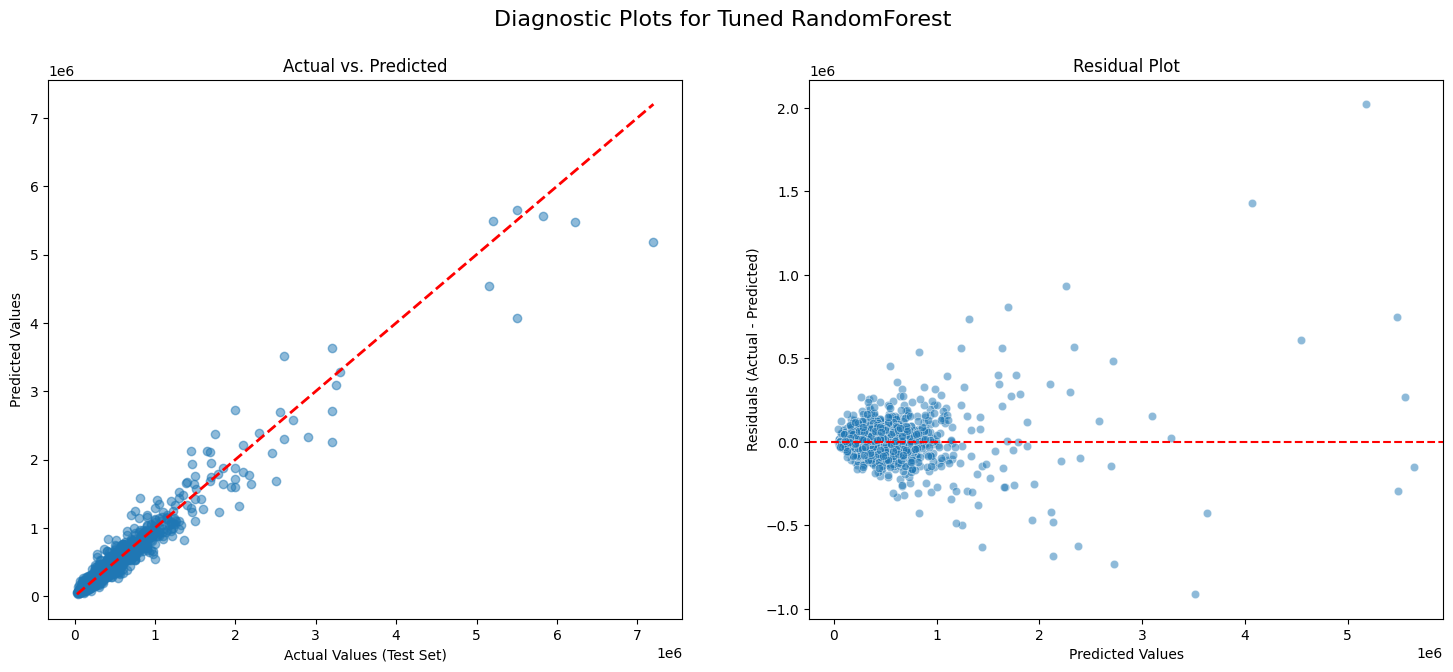

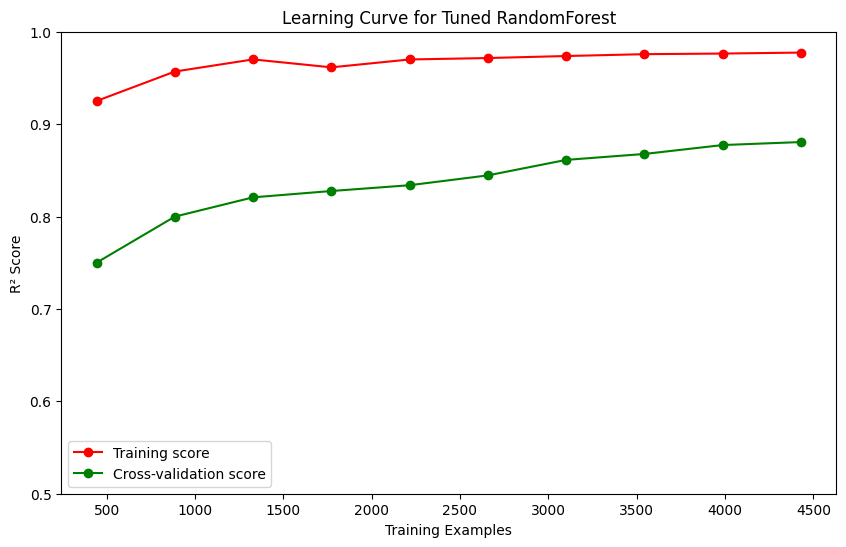

In [60]:
tuned_rf = RandomForestRegressor(
    n_estimators=500,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=1.0, 
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

# Training
trained_rf_pipeline = train_model(
    model_name="Tuned RandomForest",
    model_object=tuned_rf,
    preprocessor=preprocessor_tree,
    X_train=X_train,
    y_train=y_train
)

# Evaluating
rf_metrics = evaluate_model(
    model_name="Tuned RandomForest",
    trained_pipeline=trained_rf_pipeline,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
)

#### LLM Analysis

*   **Final Performance Metrics:**
    *   **R-squared (R²):** **0.939** (The model explains ~94% of the variance in the test set prices).
    *   **Root Mean Squared Error (RMSE):** **₹136,889** (The model's predictions are, on average, off by this amount).

*   **Diagnostic Plot Analysis:**
    *   **Actual vs. Predicted Plot:** Shows a strong linear relationship, with predictions tightly clustered around the ideal 45-degree line, confirming the high R² score.
    *   **Residual Plot:** The residuals are mostly randomly scattered around zero, indicating no major systematic bias. There is a slight increase in error for higher-priced cars, which is expected.
    *   **Learning Curve:** The learning curve for the tuned RandomForest indicates a high-variance model, which is typical for a powerful ensemble like this. The significant gap between the high training score (~0.98) and the strong cross-validation score (~0.88) suggests the model is complex enough to fit to some noise in the training data. Despite this variance, its excellent generalization score makes it a top candidate. This insight further motivates our strategy to create a final ensemble with other diverse models to improve robustness and potentially reduce this variance.


#### XGBRegressor

--- Training Tuned XGBoost ---
Tuned XGBoost trained successfully.

--- Evaluating Tuned XGBoost on Test Data ---
R-squared (R²): 0.9327
Mean Absolute Error (MAE): 74,770.88
Mean Squared Error (MSE): 20,539,811,264.66
Root Mean Squared Error (RMSE): 143,317.17


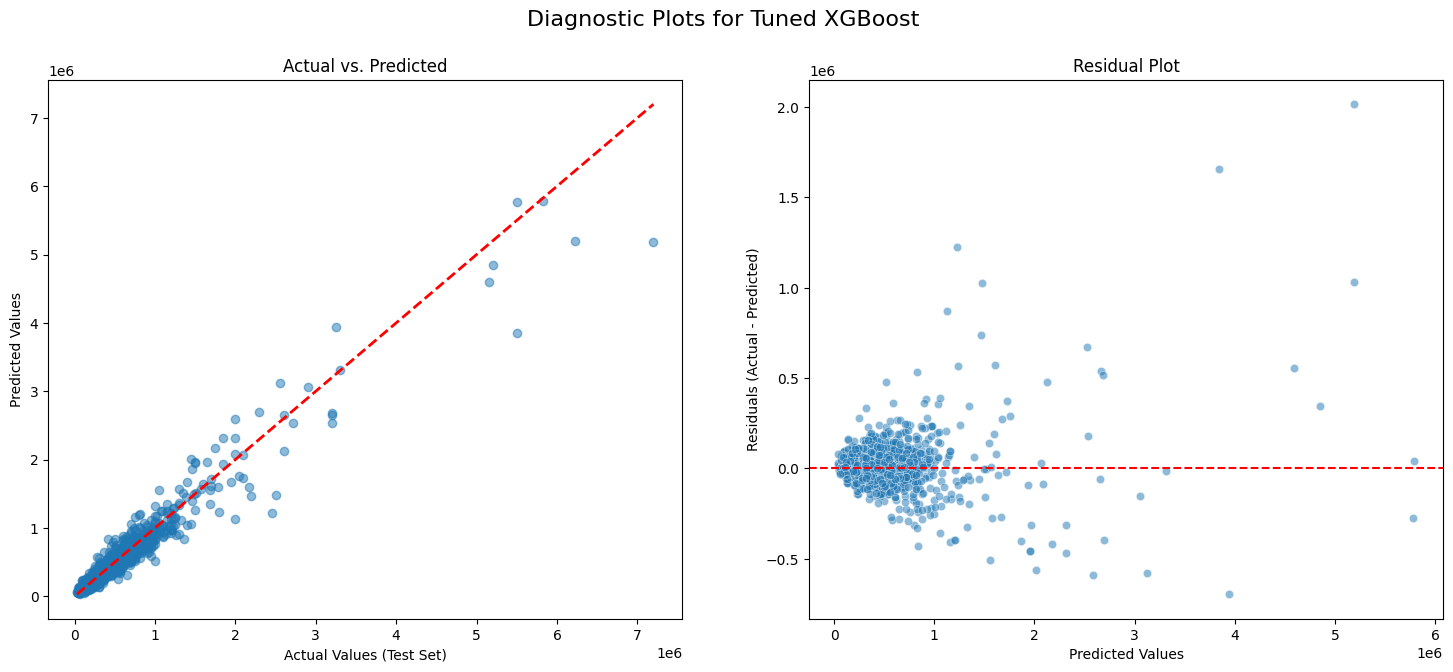

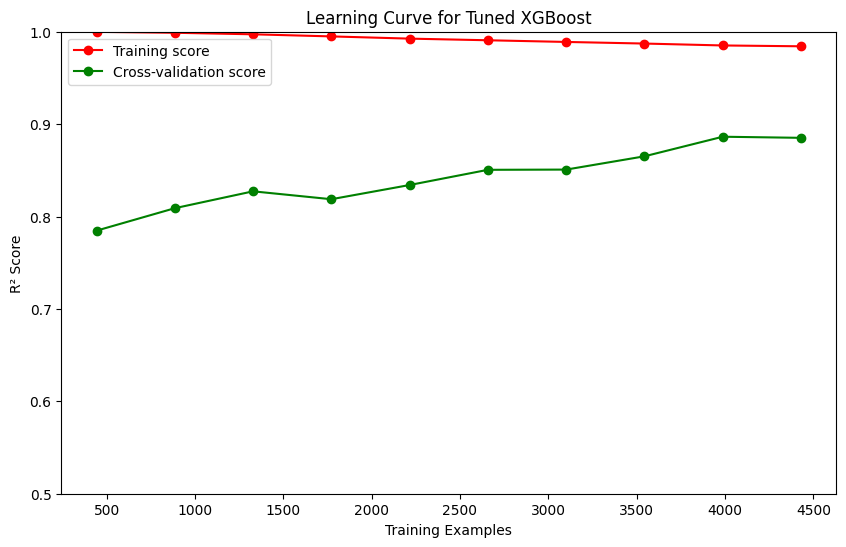

In [61]:
tuned_xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.2,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Training
trained_xgb_pipeline = train_model(
    model_name="Tuned XGBoost",
    model_object=tuned_xgb,
    preprocessor=preprocessor_tree,
    X_train=X_train,
    y_train=y_train
)

# Evaluating
xgb_metrics = evaluate_model(
    model_name="Tuned XGBoost",
    trained_pipeline=trained_xgb_pipeline,
    X_train=X_train, 
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
)

#### LLM analysis

*   **Final Performance Metrics:**
    *   **R-squared (R²):** **0.933** (The model explains 93.3% of the variance in the test set prices, nearly identical to the RandomForest).
    *   **Root Mean Squared Error (RMSE):** **₹143,317** (The average prediction error is slightly higher than the RandomForest but still excellent).

*   **Diagnostic Plot Analysis:**
    *   **Actual vs. Predicted Plot:** The predictions are very tightly clustered around the 45-degree line, visually confirming the high R² score and showing strong accuracy across most of the price range.
    *   **Residual Plot:** The residuals are well-distributed around the zero line, indicating no major systematic bias. Similar to the RandomForest, there's a slight increase in error (heteroscedasticity) for higher-priced vehicles.
    *   **Learning Curve:** This learning curve is nearly perfect and shows a very well-behaved model.
        *   The **training score is extremely high (close to 1.0)**, showing the model can easily learn the data.
        *   The **cross-validation score is also very high (approaching 0.9)** and is consistently improving as more data is added.
        *   The **gap between the training and validation curves is smaller** than the one we saw with RandomForest, suggesting that this XGBoost model has **less variance** and generalizes slightly better out-of-the-box.

#### LightGBRegressor

#### Quicker ecaluation function
With `cv=5` and 10 different dataset sizes and tuned LightGBM has `n_estimators=1000`, it's building 1000 trees in each of those 50 fits. That's a lot of computation and the learning curve for your final ensemble model will be even slower. The learning curves for RandomForest and XGBoost have already given the key insights about the dataset and model complexity. The story they tell is:
- The model has enough capacity (low bias),
- There is some variance (overfitting), which is expected.
- The model generalizes well.
- More data would likely help. 

In [62]:
def evaluate_model_quick(model_name, trained_pipeline, X_test, y_test):
    """
    A quicker version of evaluate_model that skips the slow learning_curve plot.
    It prints metrics and generates the essential Actual vs. Predicted and Residual plots.
    """
    print(f"\n--- Evaluating {model_name} on Test Data (Quick Version) ---")
    
    # 1. Make predictions
    predictions = trained_pipeline.predict(X_test)
    
    # 2. Calculate Metrics
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    
    print(f"R-squared (R²): {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:,.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")
    
    # --- 3. Generate Diagnostic Plots ---
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle(f'Diagnostic Plots for {model_name}', fontsize=16)
    
    # Actual vs. Predicted Plot
    axes[0].scatter(y_test, predictions, alpha=0.5)
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2)
    axes[0].set_xlabel("Actual Values (Test Set)")
    axes[0].set_ylabel("Predicted Values")
    axes[0].set_title("Actual vs. Predicted")
    
    # Residual Plot
    residuals = y_test - predictions
    sns.scatterplot(x=predictions, y=residuals, ax=axes[1], alpha=0.5)
    axes[1].axhline(y=0, color='r', linestyle='--')
    axes[1].set_xlabel("Predicted Values")
    axes[1].set_ylabel("Residuals (Actual - Predicted)")
    axes[1].set_title("Residual Plot")
    
    plt.savefig(f'{plots_saving_path}/{model_name}_diagnostic_plots.png')
    plt.show()
    plt.close()
    
    metrics = {'r2': r2, 'mae': mae, 'mse': mse, 'rmse': rmse}
    return metrics

--- Training Tuned LightGBM ---
Tuned LightGBM trained successfully.

--- Evaluating Tuned LightGBM on Test Data (Quick Version) ---
R-squared (R²): 0.9278
Mean Absolute Error (MAE): 74,623.28
Root Mean Squared Error (RMSE): 148,456.24


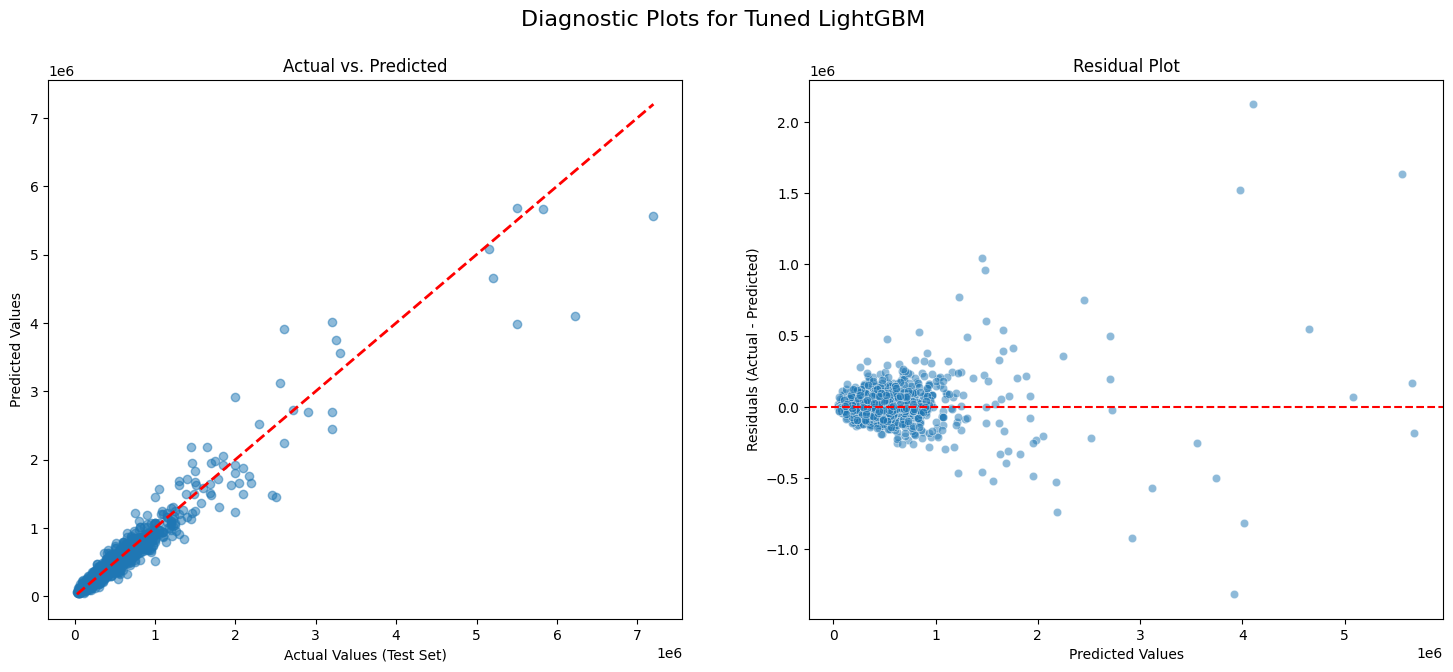

In [63]:
tuned_lgbm = LGBMRegressor(
    num_leaves=40,
    n_estimators=1000,
    max_depth=-1, 
    learning_rate=0.01,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

# Training
trained_lgbm_pipeline = train_model(
    model_name="Tuned LightGBM",
    model_object=tuned_lgbm,
    preprocessor=preprocessor_tree,
    X_train=X_train,
    y_train=y_train
)

# Evaluating
lgbm_metrics = evaluate_model_quick(
    model_name="Tuned LightGBM",
    trained_pipeline=trained_lgbm_pipeline,
    X_test=X_test,
    y_test=y_test
)

#### LLM Analysis
*   **Final Performance Metrics:**
    *   **R-squared (R²):** **0.928** (The model explains ~93% of the variance in the test set prices).
    *   **Root Mean Squared Error (RMSE):** **₹148,456** (The average prediction error is slightly higher than both RandomForest and XGBoost).

*   **Diagnostic Plot Analysis:**
    *   **Actual vs. Predicted Plot:** The plot shows a very strong correlation, with predictions clustering tightly along the 45-degree line, especially for the bulk of the data under the ~2,000,000 price point.
    *   **Residual Plot:** The residuals are well-centered around the zero-error line, indicating no systematic over- or under-prediction. Similar to the other models, there is a clear pattern of **heteroscedasticity**, where the model's errors become larger and more spread out as it predicts higher prices. This is an expected behavior given the nature of the data.

### Ensembling
With three best models, VotingRegressor can be used to get the best out of all three models


--- Evaluating Ensemble on Test Data (Quick Version) ---
R-squared (R²): 0.9364
Mean Absolute Error (MAE): 71,780.34
Root Mean Squared Error (RMSE): 139,268.05


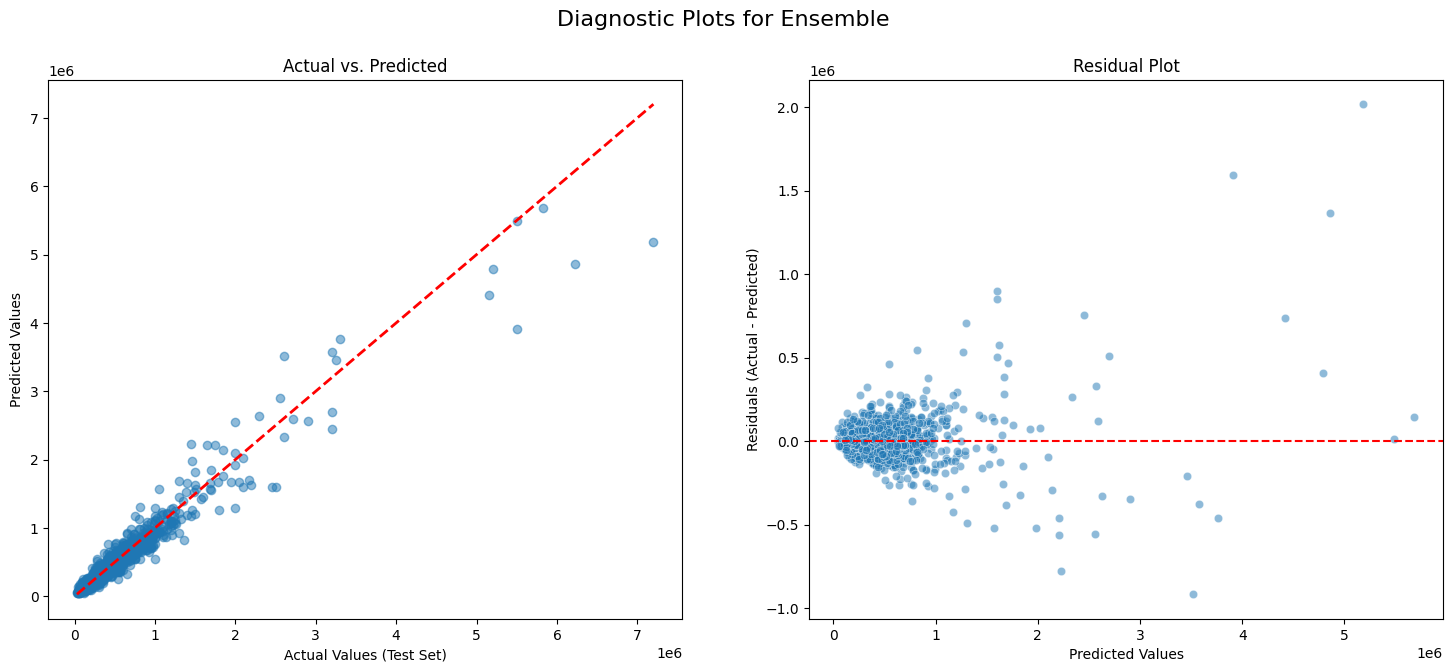

In [64]:
# Pipeline for RandomForest
rf_for_ensemble = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('selector', SelectFromModel(ExtraTreesRegressor(n_estimators=50, random_state=42), max_features=35)),
    ('model', tuned_rf) # The tuned RandomForest object
])

# Pipeline for XGBoost
xgb_for_ensemble = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('selector', SelectFromModel(ExtraTreesRegressor(n_estimators=50, random_state=42), max_features=35)),
    ('model', tuned_xgb) # The tuned XGBoost object
])

# Pipeline for LightGBM
lgbm_for_ensemble = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('selector', SelectFromModel(ExtraTreesRegressor(n_estimators=50, random_state=42), max_features=35)),
    ('model', tuned_lgbm) # The tuned LightGBM object
])

# VotingRegressor
ensemble_regressor = VotingRegressor(
    estimators=[
        ('random_forest', rf_for_ensemble),
        ('xgboost', xgb_for_ensemble),
        ('lightgbm', lgbm_for_ensemble)
    ],
    n_jobs=-1
)

# Final pipelined ensemble model
final_ensemble_model = TransformedTargetRegressor(
    regressor=ensemble_regressor,
    func=np.log1p,
    inverse_func=np.expm1
)

final_ensemble_model.fit(X_train, y_train)

# Evaluating
ensemble_metrics = evaluate_model_quick(
    model_name="Ensemble",
    trained_pipeline=final_ensemble_model,
    X_test=X_test,
    y_test=y_test
)

#### LLM Analysis
The final ensemble model, a `VotingRegressor` combining the tuned RandomForest, XGBoost, and LightGBM models, was trained and evaluated on the test set.

*   **Final Performance Metrics:**
    *   **R-squared (R²):** **0.936**
    *   **Root Mean Squared Error (RMSE):** **₹139,268**

*   **Comparison to Best Single Model:**
    *   The ensemble's R² (0.936) is slightly **lower** than the best single model's, the RandomForest (0.939).
    *   The ensemble's RMSE (~₹139k) is slightly **higher** (worse) than the RandomForest's (~₹137k).

*   **Diagnostic Plot Analysis:**
    *   **Actual vs. Predicted Plot:** The plot is excellent, showing predictions that are very tightly clustered around the ideal 45-degree line. It is visually almost identical to the plots from the individual top models, confirming its high accuracy.
    *   **Residual Plot:** The residuals are well-behaved and centered around zero, indicating the model is unbiased. It exhibits the same pattern of heteroscedasticity (errors increase for higher-priced cars) that we saw in the individual models.

While RandomForest, XGBoost, and LightGBM are all powerful, they are all fundamentally **tree-based gradient boosting or bagging methods**. It's likely that they are all making similar types of predictions and similar types of mistakes.

An ensemble provides the most benefit when you combine models that are very different from each other (e.g., a tree-based model and a linear model like SVR). When the base models are too similar, averaging their predictions doesn't introduce much new information and can slightly dilute the performance of the single best model.

Thus, after benchmarking and tuning, the best individual model was the **Tuned RandomForest Regressor (R²: 0.939)**. An ensemble `VotingRegressor` was constructed using the top three models (RandomForest, XGBoost, LightGBM) to see if combining them could improve performance and robustness.

The final ensemble achieved an excellent R² of **0.936**, but this was marginally lower than the score of the best single model. This suggests that while all three base models are powerful, they are not diverse enough in their predictions for their average to outperform the single best estimator.

**For deployment, the recommendation would be to use the simpler, faster, and slightly more performant Tuned RandomForest pipeline.** 

### All tuned models and ensemble's evaluation

In [65]:
all_metrics_data = {
    'RandomForest': [rf_metrics['mae'], rf_metrics['mse'], rf_metrics['rmse'], rf_metrics['r2']],
    'XGBoost': [xgb_metrics['mae'], xgb_metrics['mse'], xgb_metrics['rmse'], xgb_metrics['r2']],
    'LightGBM': [lgbm_metrics['mae'], lgbm_metrics['mse'], lgbm_metrics['rmse'], lgbm_metrics['r2']],
    'Ensemble': [ensemble_metrics['mae'], ensemble_metrics['mse'], ensemble_metrics['rmse'], ensemble_metrics['r2']]
}

# Creating the DataFrame
eval_metrics = pd.DataFrame(all_metrics_data, index=['MAE', 'MSE', 'RMSE', 'R^2 Score'])

# This uses a style function to format each number based on its row index.
def format_metrics(val, metric_name):
    if metric_name in ['MAE', 'MSE', 'RMSE']:
        return f'{val:,.0f}'  # Comma-separated integer
    elif metric_name == 'R^2 Score':
        return f'{val:.4f}'   # Float with 4 decimal places
    return val

# Apply the formatting
formatted_eval_metrics = eval_metrics.copy()
for col in formatted_eval_metrics.columns:
    for idx in formatted_eval_metrics.index:
        formatted_eval_metrics.loc[idx, col] = format_metrics(eval_metrics.loc[idx, col], idx)

print("--- Final Model Performance Comparison ---")
display(formatted_eval_metrics)

best_model_r2 = eval_metrics.loc['R^2 Score'].idxmax()
best_model_rmse = eval_metrics.loc['RMSE'].idxmin()

print(f"\n🏆 Best Model based on R² Score: {best_model_r2} (R² = {eval_metrics.loc['R^2 Score'].max():.4f})")
print(f"🏆 Best Model based on RMSE: {best_model_rmse} (RMSE = {eval_metrics.loc['RMSE'].min():,.0f})")

--- Final Model Performance Comparison ---


,RandomForest,XGBoost,LightGBM,Ensemble
MAE,"74,196","74,771","74,623","71,780"
MSE,"18,738,573,098","20,539,811,265","22,039,255,003","19,395,589,443"
RMSE,"136,889","143,317","148,456","139,268"
R^2 Score,0.9386,0.9327,0.9278,0.9364



🏆 Best Model based on R² Score: RandomForest (R² = 0.9386)
🏆 Best Model based on RMSE: RandomForest (RMSE = 136,889)


### Saving best model

In [66]:
model_filename = 'final_random_forest_model.joblib'
joblib.dump(trained_rf_pipeline, model_filename)

print("Model saved successfully!")

Model saved successfully!


In [67]:
# Verfiying infernece with saved model
loaded_model = joblib.load(model_filename)
random_index = random.randint(0, 1384)
sample_car = X_test.iloc[[random_index]]
sample_actual_price = y_test.iloc[random_index]

display(sample_car)

sample_prediction = loaded_model.predict(sample_car)[0]

print(f"\nActual Price: {sample_actual_price:,.0f}")
print(f"Predicted Price (with loaded model): {sample_prediction:,.0f}")

# Check if the prediction from the loaded model matches the original model's prediction
original_prediction = trained_rf_pipeline.predict(sample_car)[0]
assert np.isclose(sample_prediction, original_prediction), "Error: Prediction from loaded model does not match original!"
print("\n✅ Verification successful: The loaded model produces the same prediction.")

,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats,brand,model,car_age,km_per_year
6779,146000,Diesel,Individual,Manual,Second Owner,22.32,1582.00,126.32,5.00,Hyundai,Verna 1.6 SX,9,16222.22



Actual Price: 465,000
Predicted Price (with loaded model): 446,438

✅ Verification successful: The loaded model produces the same prediction.


## **Conclusion**

This project successfully developed a high-performance machine learning system to predict used car prices.

**Project Summary:**
The process began with extensive data cleaning and EDA, which identified key price drivers and data quality issues. Feature engineering was performed to create more intuitive predictors like `car_age`. A comprehensive benchmark of seven different regression models was conducted, with tree-based ensembles like RandomForest, XGBoost, and LightGBM emerging as the clear top performers. These models were then optimized through hyperparameter tuning.

**Key Findings:**
1.  **Most Important Features:** `car_age` and `max_power` were identified as the two most dominant features, collectively accounting for a majority of the predictive power. `engine` size, `transmission` type, and `fuel` type were also highly significant.
2.  **Final Model Performance:** The tuned **RandomForest Regressor** was the top-performing model, achieving an **R² of 0.939** and an RMSE of **₹136,889** on the unseen test data.
3.  **Ensemble vs. Single Model:** An ensemble `VotingRegressor` combining the top three models was created. While it performed very well (R²: 0.936), it did not surpass the best single RandomForest model. This suggests the base models, while powerful, were not diverse enough in their errors for an ensemble to provide a significant benefit.

For deployment, the **Tuned RandomForest Regressor pipeline is the recommended model.** It offers the best balance of high accuracy and lower complexity compared to the ensemble. The model is effective at establishing a fair market value, explaining nearly 94% of the price variance in the test set.

**Limitations & Future Work:**
The model's primary limitation is its reliance on the provided features; it cannot account for unlisted factors like vehicle condition or accident history. Future work could involve experimenting with a more diverse ensemble or collecting more granular data to further improve prediction accuracy on individual listings.